# Introduction

This project is to make EDA and prediction on the Hong Kong Housing Price. We webscraped transaction data from Midland Property. We sampled 457 estates and 2245 residential buildings from the website. We also manually created new variables in the dataset including Distance from the nearest MTR station (DisMTR(km)), Distance from the CBD (DisCBD(km)), and if it is in Elite SchoolZone.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns

Here we import precleaned and prefilled csv file for analysis

In [2]:
df = pd.read_csv('data2018_1.csv')

In [3]:
df

,Price(M),Floor,Area (Saleable),Trans Date,Age,Club,DisMTR(km),DisCBD(km),SchoolZone
0,1250,62,482,17/8/2018,17.67,1,1.00,13.8,0
1,1169,61,604,14/5/2018,17.67,1,1.00,13.8,0
2,864,59,604,16/5/2018,17.67,1,1.00,13.8,0
3,888,48,455,28/8/2018,17.67,1,1.00,13.8,0
4,770,41,451,7/2/2018,17.67,1,1.00,13.8,0
...,...,...,...,...,...,...,...,...,...
15387,600,37,354,15/10/2018,24.50,1,0.55,17.3,0
15388,728,31,578,6/7/2018,24.50,1,0.55,17.3,0
15389,808,22,578,16/8/2018,24.50,1,0.55,17.3,0
15390,600,21,413,5/7/2018,24.50,1,0.55,17.3,0


In [4]:
df1 = df.copy()

In [5]:
df1.describe()

,Price(M),Floor,Area (Saleable),Age,Club,DisMTR(km),DisCBD(km),SchoolZone
count,15392.000000,15392.000000,15392.000000,15392.000000,15392.000000,15392.000000,15392.000000,15392.000000
mean,939.905795,19.234213,568.589657,21.870824,0.738046,1.072369,17.561214,0.191593
std,966.727765,13.493344,247.560421,12.408104,0.439712,1.289750,11.103388,0.393567
min,126.000000,1.000000,121.000000,0.000000,0.000000,0.010000,2.200000,0.000000
25%,540.000000,9.000000,426.000000,13.500000,0.000000,0.350000,8.700000,0.000000
50%,703.000000,17.000000,511.000000,20.750000,1.000000,0.700000,13.800000,0.000000
75%,978.000000,27.000000,649.000000,31.670000,1.000000,1.500000,29.300000,0.000000
max,34400.000000,87.000000,3962.000000,59.750000,1.000000,9.200000,42.300000,1.000000


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15392 entries, 0 to 15391
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price(M)         15392 non-null  int64  
 1   Floor            15392 non-null  int64  
 2   Area (Saleable)  15392 non-null  int64  
 3   Trans Date       15392 non-null  object 
 4   Age              15392 non-null  float64
 5   Club             15392 non-null  int64  
 6   DisMTR(km)       15392 non-null  float64
 7   DisCBD(km)       15392 non-null  float64
 8   SchoolZone       15392 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 1.1+ MB


# Data cleaning

Here we will extract month from the `Trans Date` column, since there is peak season for housing transaction.

In [7]:
df1['Trans Date'] = pd.to_datetime(df1['Trans Date'])
df1['month'] = df1['Trans Date'].dt.month
df1.drop('Trans Date',axis=1, inplace=True)

Here we will visualize the distribution of the data

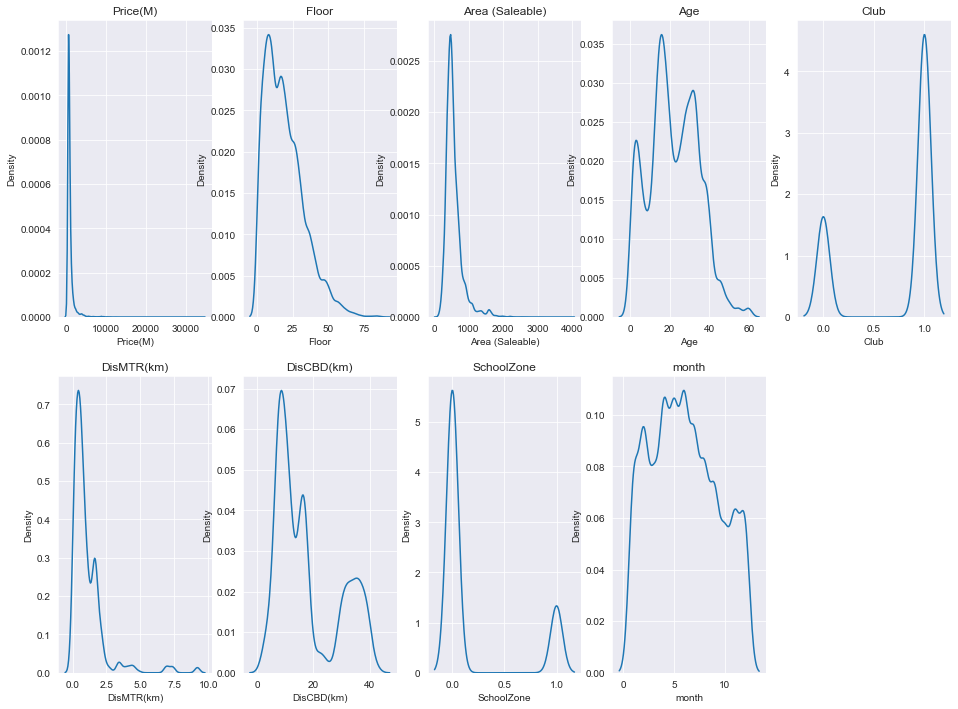

In [8]:
plt.figure(figsize=[16,12])
sns.set_style("darkgrid")

for i, col in zip(range(251,260), df1.columns):
    plt.subplot(i)
    sns.kdeplot(data=df1, x=col)
    plt.title(col)

In [9]:
print('kurtosis')
print(df1.kurtosis())
print('-'*50)
print('skewness')
print(df1.skew())

kurtosis
Price(M)           153.567111
Floor                0.962087
Area (Saleable)     10.844245
Age                 -0.505912
Club                -0.827489
DisMTR(km)          15.585337
DisCBD(km)          -0.863973
SchoolZone           0.456935
month               -0.996728
dtype: float64
--------------------------------------------------
skewness
Price(M)           8.417532
Floor              0.985219
Area (Saleable)    2.481992
Age                0.217062
Club              -1.082875
DisMTR(km)         3.518502
DisCBD(km)         0.769894
SchoolZone         1.567442
month              0.197909
dtype: float64


We can see our target variable is has high Kurtosis and skewness. Other variables also tend to skew to the left. We may need to normalize the data.

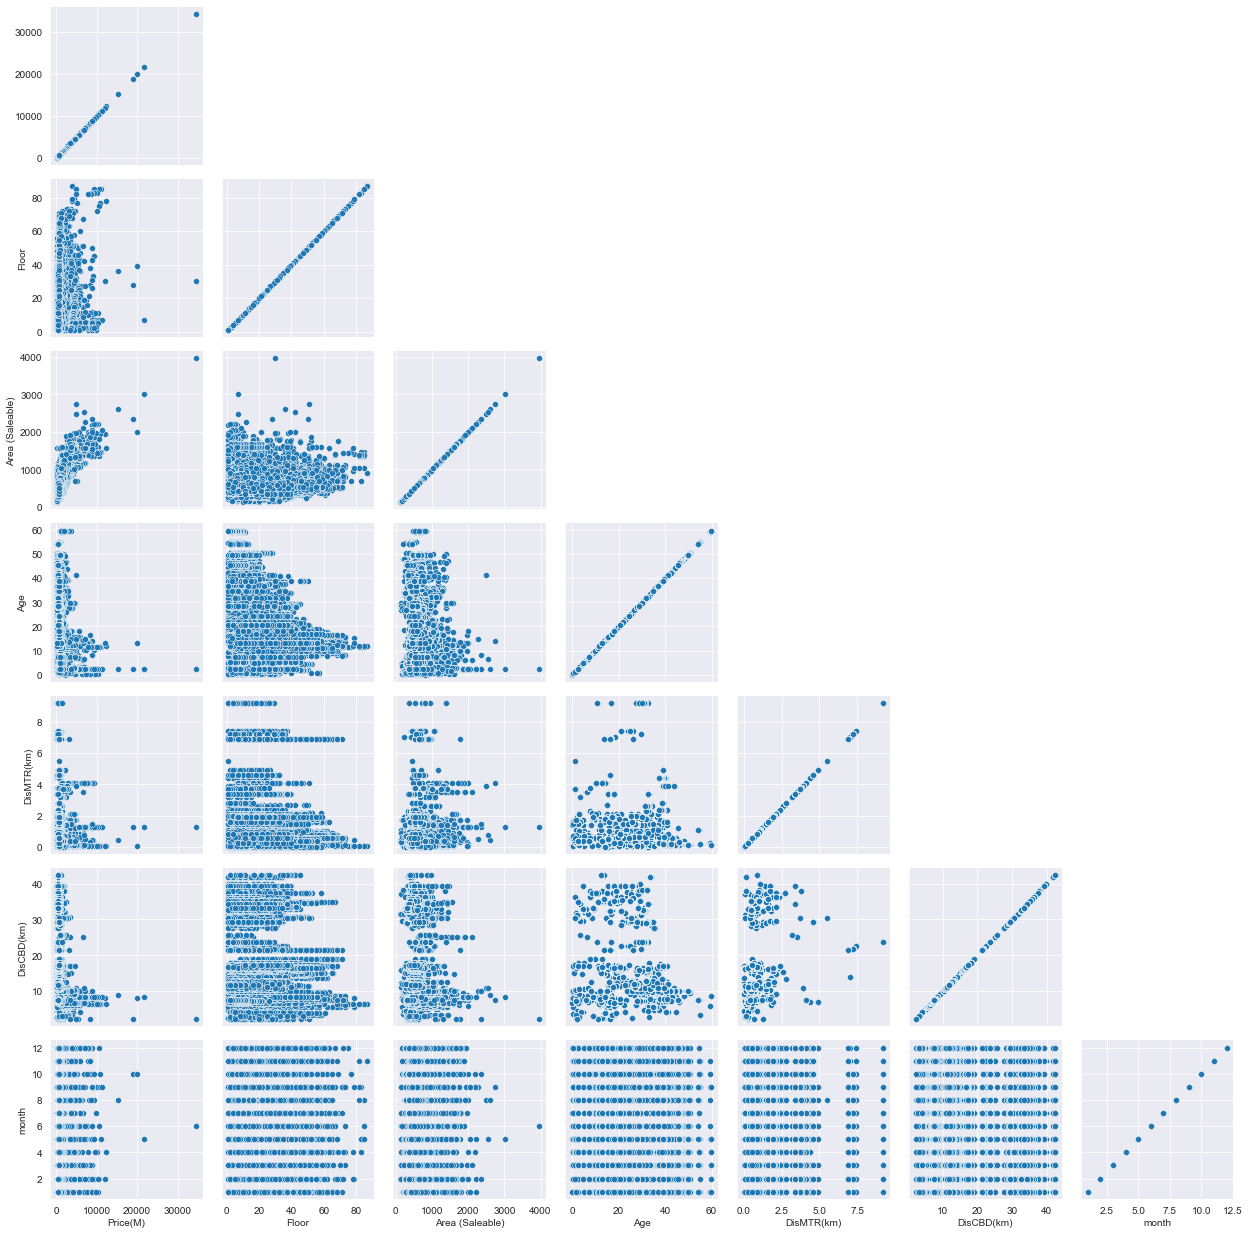

In [10]:
variables = ['Price(M)', 'Floor', 'Area (Saleable)', 'Age', 'DisMTR(km)',
       'DisCBD(km)',  'month']
g = sns.PairGrid(df1, diag_sharey=False, corner=True, vars=variables)
g.map(sns.scatterplot)

We can see there is only significant linear relationship between Price and Area. From the scatter plot we can't observe explicit relationship between Price and other variables

# Outlier Detection and Removal

We can see price and area are have some outliers from the scatter plot above and the boxplot below. We will remove those outliers to have a better model prediction.

<AxesSubplot:xlabel='Area (Saleable)'>

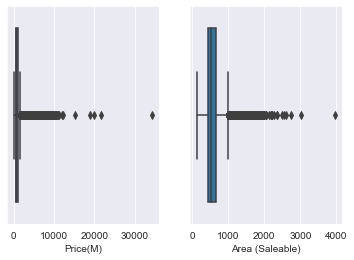

In [11]:
plt.subplot(121)
sns.boxplot(x='Price(M)', data=df1)

plt.subplot(122)
sns.boxplot(x='Area (Saleable)', data=df1)



In [12]:
from scipy.stats import zscore
zscore(df1['Price(M)'])

array([ 0.32077725,  0.23698673, -0.07852082, ..., -0.13645008,
       -0.35161588, -0.2605842 ])

In [13]:
lower_bound = -2.576
upper_bound = 2.576

df2 = df1[ ~ ((zscore(df1['Price(M)'])< lower_bound) | (zscore(df1['Price(M)']) > upper_bound) )]
df3 = df2[ ~ ((zscore(df2['Area (Saleable)'])< lower_bound) | (zscore(df2['Area (Saleable)']) > upper_bound) )]
df4 = df3[ ~ ((zscore(df3['Floor'])< lower_bound) | (zscore(df3['Floor']) > upper_bound) )]
df4 = df4.reset_index(drop=True)

In [14]:
df4

,Price(M),Floor,Area (Saleable),Age,Club,DisMTR(km),DisCBD(km),SchoolZone,month
0,888,48,455,17.67,1,1.00,13.8,0,8
1,770,41,451,17.67,1,1.00,13.8,0,7
2,930,40,566,17.67,1,1.00,13.8,0,5
3,833,38,451,17.67,1,1.00,13.8,0,1
4,788,33,451,17.67,1,1.00,13.8,0,2
...,...,...,...,...,...,...,...,...,...
14360,600,37,354,24.50,1,0.55,17.3,0,10
14361,728,31,578,24.50,1,0.55,17.3,0,6
14362,808,22,578,24.50,1,0.55,17.3,0,8
14363,600,21,413,24.50,1,0.55,17.3,0,5


# Detecting Multicollinearity

We can see there is no strong multicollinearity problem between variables

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# We only select independent variables to test multiconllinearity
check_mc_vars = df4.drop('Price(M)',axis = 1).columns
df_check_mc = df4[check_mc_vars]

#VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_check_mc.columns
vif_data["VIF"] = [variance_inflation_factor(df_check_mc.values, i)
                          for i in range(len(df_check_mc.columns))]

print(vif_data)

           feature       VIF
0            Floor  3.191551
1  Area (Saleable)  8.860506
2              Age  3.503859
3             Club  4.396204
4       DisMTR(km)  1.825158
5       DisCBD(km)  4.109921
6       SchoolZone  1.436835
7            month  4.076664


# Variable relationship exploration

We will examine the correlation between the variable first. We can see there is no strong correlation between each variable. Month shows a very weak correlation with price and other variables.

<AxesSubplot:>

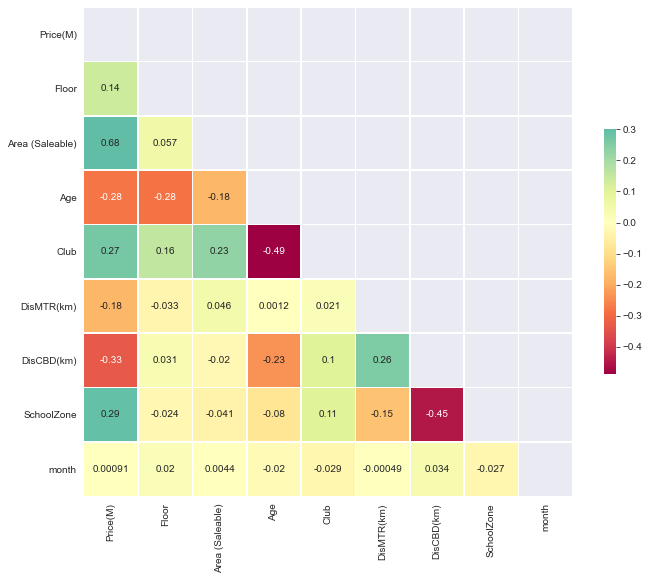

In [16]:
# Compute the correlation matrix
corr = df4.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Exploring relationships between variables

We band various variable for simpler visualization.

1. `Floor`: 
            0 : 0 to 5 
            1 : 5 to 10 
            2 : 10 to 15 
            3 : 15 to 20 
            4 : 20 to 30 
            5 : 30 to 90 
           
2. `Area (Saleable)`:
            0 : 100 to 200 
            1 : 200 to 300 
            2 : 300 to 400 
            3 : 400 to 500 
            4 : 500 to 600 
            5 : 600 to 700 
            6 : 700 to 800 
            7 : 800 to 900 
            8 : 900 to 1000 
            
3. `DisMTR(km)`:
            0 : 0 to 0.5 
            1 : 0.5 to 1 
            2 : 1 to 1.5 
            3 : 1.5 to 2 
            4 : 2 to 10 
            
4. `DisCBD(km)`:
            0 : 2.15 to 6.21
            1 : 6.21 to 10.21
            2 : 10.21 to 14.23
            3 : 14.23 to 18.24
            4 : 18.24 to 22.24
            5 : 22.24 to 26.25
            6 : 26.25 to 30.27
            7 : 30.27 to 34.28
            8 : 34.28 to 38.29
            9 : 38.29 to 42.3 
        
5. `Age` :
            0 : 0 to 5.975
            1 : 5.975 to 11.95
            2 : 11.95 to 17.92
            3 : 17.92 to 23.9
            4 : 23.9 to 29.875
            5 : 29.875 to 35.84
            6 : 35.84 to 41.82
            7 : 41.82 to 47.8
            8 : 47.8 to 53.775
            9 : 53.775 to 59.75


In [17]:
df4['Floor_bin'] = pd.cut(df4['Floor'], bins=[0,5,10,15,20,30,90], labels=[i for i in range(6)])
df4['Area_bin'] = pd.cut(df4['Area (Saleable)'], bins=[i for i in range(100,1100,100)],labels=[i for i in range(9)])
df4['DisMTR_bin'] = pd.cut(df4['DisMTR(km)'], bins=[0,0.5,1,1.5,2,10],labels=[i for i in range(5)])
df4['DisCBD_bin'] = pd.cut(df4['DisCBD(km)'], bins=10,labels=[i for i in range(10)])
df4['Age_bin'] = pd.cut(df4['Age'], bins=10,labels=[i for i in range(10)])

Age distribution

<AxesSubplot:xlabel='Age_bin', ylabel='count'>

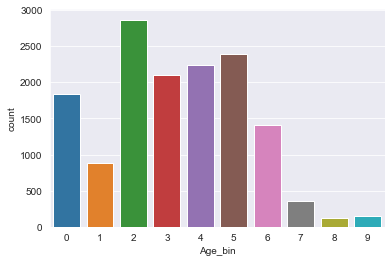

In [18]:
sns.countplot(x='Age_bin',data=df4)

Clubhouse Distribution

<AxesSubplot:xlabel='Club', ylabel='count'>

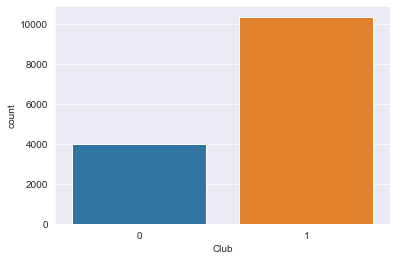

In [19]:
sns.countplot(x='Club',data=df4)

SchoolZone Distribution

<AxesSubplot:xlabel='SchoolZone', ylabel='count'>

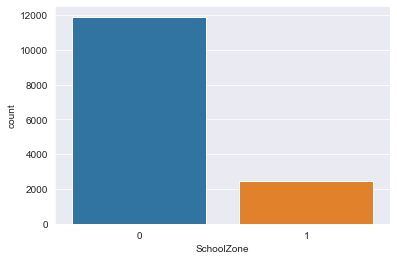

In [20]:
sns.countplot(x='SchoolZone',data=df4)

The flats with clubhouse tend to have a higher price in all price range

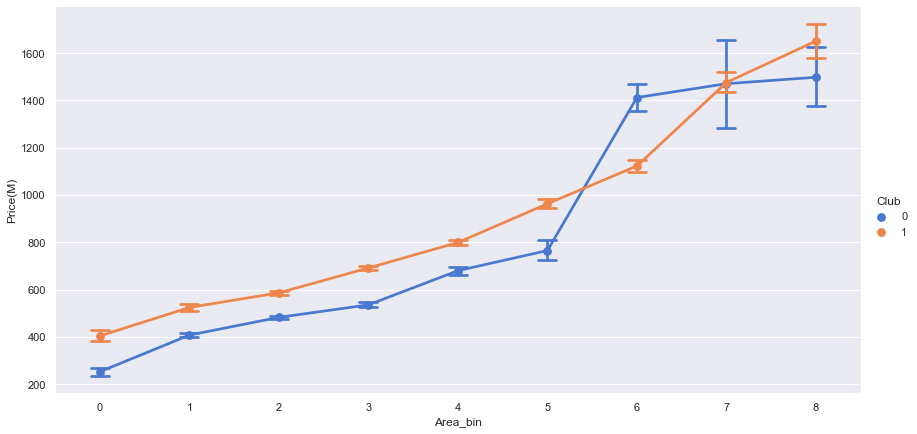

In [21]:
sns.set(rc={'figure.figsize':(20,12)})
PriceAreaClub_plot = sns.catplot(x='Area_bin', y="Price(M)", hue="Club",
                capsize=.2, palette="muted", height=6, aspect=2,
                kind="point", data=df4)

The buildings in SchoolZone tend to be more expensive.

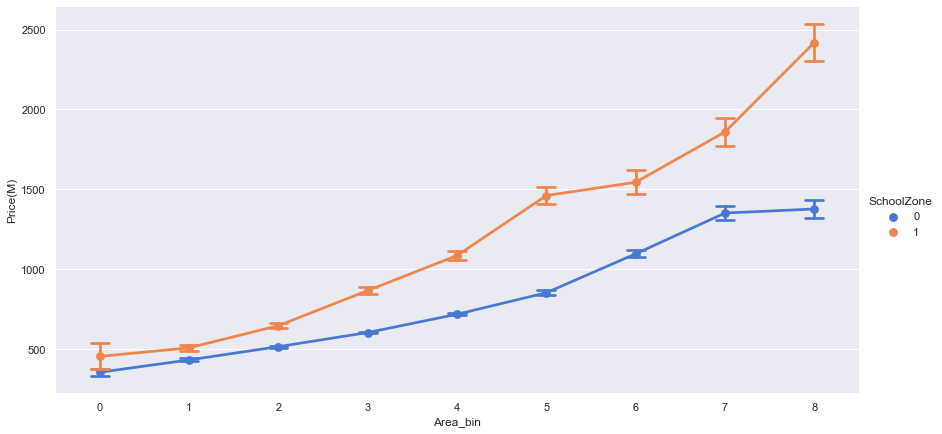

In [22]:
PriceSchool_plot = sns.catplot(x='Area_bin', y="Price(M)", hue="SchoolZone",
                capsize=.2, palette="muted", height=6, aspect=2,
                kind="point", data=df4)

The further the building from the CBD the lower the price is.

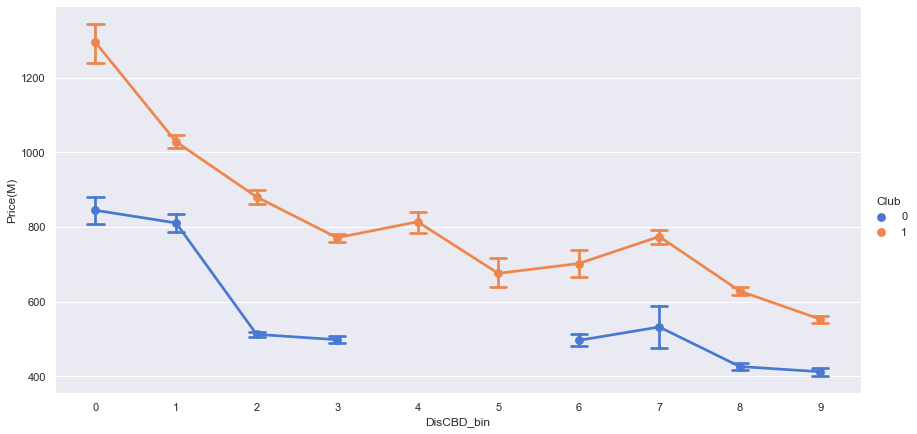

In [23]:
PriceAreaSchool_plot = sns.catplot(x='DisCBD_bin', y="Price(M)", hue="Club",
                capsize=.2, palette="muted", height=6, aspect=2,
                kind="point", data=df4)

The closer the building being near the MTR station does not necessarily imply higher price

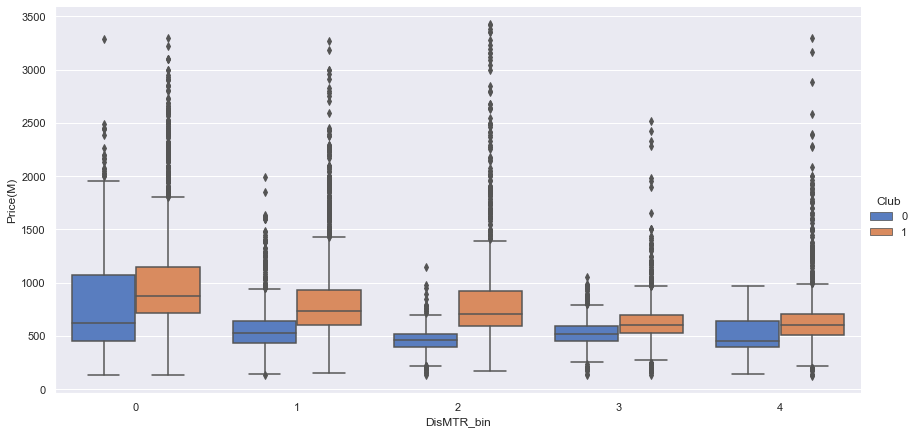

In [24]:
PriceDisMTR_plot = sns.catplot(x='DisMTR_bin', y="Price(M)", hue="Club",
                 palette="muted", height=6, aspect=2,
                kind="box", data=df4)

We can observe the Price, Age, Area relationship in this plot. The price tends to be higher with smaller age and larger area

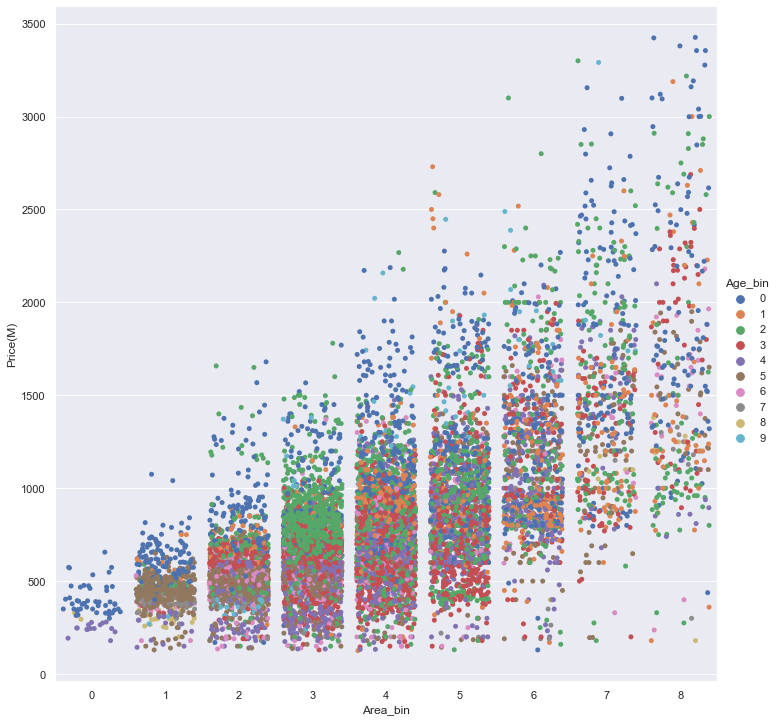

In [25]:
PriceAreaAge_plot = sns.catplot(x='Area_bin', y="Price(M)", hue="Age_bin", height=10, aspect=1,jitter=0.4,
            kind="strip", data=df4)

We can observe flats on a lower floor tends to have a higher price with the increase in area. However, when it comes to a higher floor, the difference in area does not neccessarily determine the price

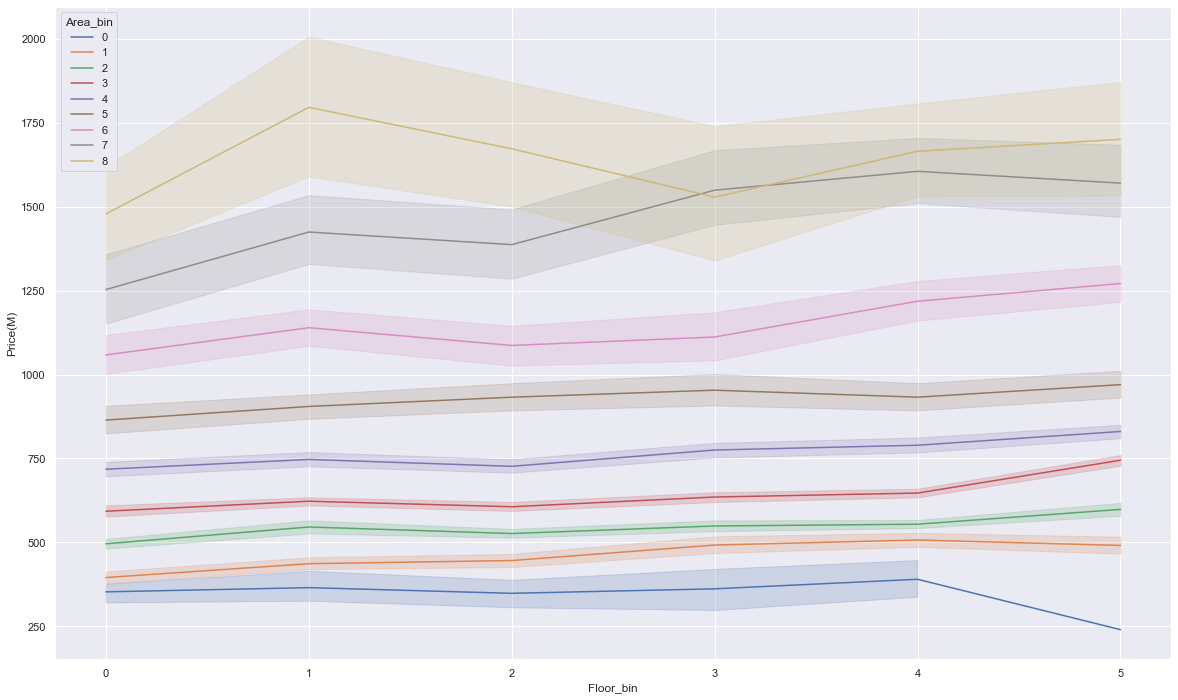

In [26]:
PriceFloorAge_plot = sns.lineplot(data=df4,x="Floor_bin", 
                                  y="Price(M)",hue="Area_bin")

# PCA analysis
Now we'll do PCA analysis to examine where there are principal components with high MI scores and can replace the variables in our original dataset

In [27]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

We will first standardize our variables for PCA analysis

In [28]:
pca_vars = ['Floor', 'Area (Saleable)', 'Age', 
            'DisMTR(km)','DisCBD(km)']
PCA_X = df4.copy()
PCA_y = PCA_X.pop('Price(M)')
PCA_X = PCA_X.loc[:,pca_vars]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(PCA_X)
pca_x_scaled = pd.DataFrame(x_scaled,columns=[pca_vars])

In [29]:
pca = PCA()
X_pca = pca.fit_transform(pca_x_scaled)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

In [30]:
loadings = pd.DataFrame(
    pca.components_.T,  
    columns=component_names,  
    index=PCA_X.columns,
)
loadings

,PC1,PC2,PC3,PC4,PC5
Floor,0.442465,-0.439177,-0.353609,0.617623,-0.323807
Area (Saleable),0.304277,-0.238612,0.876157,-0.035745,-0.285571
Age,-0.635813,0.243853,0.093745,0.348487,-0.637218
DisMTR(km),0.266472,0.658562,0.219584,0.578702,0.334926
DisCBD(km),0.486184,0.506971,-0.224284,-0.401155,-0.543486


In [31]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [32]:
mi_scores = make_mi_scores(X_pca, PCA_y, discrete_features=False)
mi_scores

PC2    0.319030
PC3    0.226706
PC1    0.083155
PC5    0.055951
PC4    0.025310
Name: MI Scores, dtype: float64

We can see PCA1 which is the component having the most information, which only accounts for 30% of variance. We may not use PCA components in machine learning

# Data preprocessing for machine learning

In [33]:
# import sklearn librabries

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Lasso,Ridge,BayesianRidge,ElasticNet
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import ShuffleSplit,cross_validate, GridSearchCV, train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

From the above, we saw `month` has a very low correlation with the price. Therefore we'll drop it in the model training. Now we will compare the model performance with scaling and without scaling using linear regression.

In [34]:
#df5 is the dataframe that we use to train the model
df5 = df4[['Price(M)', 'Floor', 'Area (Saleable)', 'Age', 'Club', 'DisMTR(km)',
       'DisCBD(km)', 'SchoolZone']].copy()

In [35]:
X=df5.drop(['Price(M)'],axis=1)
y=df5['Price(M)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [36]:
# Test the model with scaling of feature variables
lr = LinearRegression()
process_var = ['Floor', 'Area (Saleable)', 'Age', 'DisMTR(km)',
               'DisCBD(km)']
preprocessor = make_column_transformer((StandardScaler(),process_var))
pipe = make_pipeline(preprocessor, lr)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.646660184753995

In [37]:
# Test the model without scaling
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6658272622929583

From the above, we can see the model performs slightly better without scaling the feature variables. Therefore, in the following, we will not scale the variables when testing other machine learning models.

# Initial training different ML algos

In [38]:
ML_algos = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    BayesianRidge(), 
    ElasticNet(),
    XGBRegressor(),
    CatBoostRegressor()
    ]

MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean']
MLA_df = pd.DataFrame(columns = MLA_columns)
MLA_predict = df5['Price(M)']


cv = ShuffleSplit(n_splits=5, test_size=0.2,random_state=100)

row_index = 0
for algo in ML_algos:
    MLA_name = algo.__class__.__name__
    MLA_df.loc[row_index, 'MLA Name'] = MLA_name
    MLA_df.loc[row_index, 'MLA Parameters'] = str(algo.get_params())
    
    cv_results = cross_validate(algo, X, y, cv=cv)
    MLA_df.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_df.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean() 
    
    row_index+=1
    
MLA_df.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)

Learning rate set to 0.060277
0:	learn: 390.5609618	total: 58.7ms	remaining: 58.7s
1:	learn: 375.2104766	total: 60.9ms	remaining: 30.4s
2:	learn: 360.5636949	total: 63ms	remaining: 20.9s
3:	learn: 347.5185039	total: 65.1ms	remaining: 16.2s
4:	learn: 334.9676570	total: 67.4ms	remaining: 13.4s
5:	learn: 322.9262285	total: 69.6ms	remaining: 11.5s
6:	learn: 311.9974353	total: 72.4ms	remaining: 10.3s
7:	learn: 301.6699331	total: 74.5ms	remaining: 9.23s
8:	learn: 291.9266897	total: 76.7ms	remaining: 8.45s
9:	learn: 283.1325628	total: 78.9ms	remaining: 7.81s
10:	learn: 274.7214502	total: 81ms	remaining: 7.29s
11:	learn: 267.4344953	total: 83.3ms	remaining: 6.86s
12:	learn: 259.9716784	total: 85.4ms	remaining: 6.48s
13:	learn: 253.3117524	total: 88ms	remaining: 6.2s
14:	learn: 246.7929047	total: 90.2ms	remaining: 5.92s
15:	learn: 240.9520825	total: 92.5ms	remaining: 5.69s
16:	learn: 235.5670921	total: 94.5ms	remaining: 5.47s
17:	learn: 230.6241157	total: 96.7ms	remaining: 5.27s
18:	learn: 226.

220:	learn: 141.5658870	total: 553ms	remaining: 1.95s
221:	learn: 141.4958162	total: 555ms	remaining: 1.95s
222:	learn: 141.4184704	total: 558ms	remaining: 1.94s
223:	learn: 141.2829239	total: 560ms	remaining: 1.94s
224:	learn: 141.2094695	total: 562ms	remaining: 1.94s
225:	learn: 141.0880562	total: 565ms	remaining: 1.93s
226:	learn: 141.0356120	total: 567ms	remaining: 1.93s
227:	learn: 140.9641860	total: 569ms	remaining: 1.93s
228:	learn: 140.9154252	total: 572ms	remaining: 1.93s
229:	learn: 140.8185546	total: 574ms	remaining: 1.92s
230:	learn: 140.7744589	total: 577ms	remaining: 1.92s
231:	learn: 140.7349368	total: 580ms	remaining: 1.92s
232:	learn: 140.6331700	total: 582ms	remaining: 1.92s
233:	learn: 140.5622195	total: 584ms	remaining: 1.91s
234:	learn: 140.4719495	total: 586ms	remaining: 1.91s
235:	learn: 140.4163808	total: 589ms	remaining: 1.91s
236:	learn: 140.3100436	total: 591ms	remaining: 1.9s
237:	learn: 140.2494137	total: 593ms	remaining: 1.9s
238:	learn: 140.2053354	total:

381:	learn: 131.7848555	total: 922ms	remaining: 1.49s
382:	learn: 131.7448666	total: 926ms	remaining: 1.49s
383:	learn: 131.7063656	total: 930ms	remaining: 1.49s
384:	learn: 131.6667082	total: 933ms	remaining: 1.49s
385:	learn: 131.6057031	total: 936ms	remaining: 1.49s
386:	learn: 131.5851835	total: 941ms	remaining: 1.49s
387:	learn: 131.5536417	total: 946ms	remaining: 1.49s
388:	learn: 131.5145313	total: 949ms	remaining: 1.49s
389:	learn: 131.4325065	total: 952ms	remaining: 1.49s
390:	learn: 131.3939405	total: 954ms	remaining: 1.49s
391:	learn: 131.3638830	total: 956ms	remaining: 1.48s
392:	learn: 131.3188674	total: 958ms	remaining: 1.48s
393:	learn: 131.2921067	total: 960ms	remaining: 1.48s
394:	learn: 131.2579065	total: 963ms	remaining: 1.47s
395:	learn: 131.2289983	total: 965ms	remaining: 1.47s
396:	learn: 131.1710255	total: 967ms	remaining: 1.47s
397:	learn: 131.1316599	total: 970ms	remaining: 1.47s
398:	learn: 131.1026921	total: 972ms	remaining: 1.46s
399:	learn: 131.0594643	tota

545:	learn: 125.4038151	total: 1.29s	remaining: 1.07s
546:	learn: 125.3863615	total: 1.29s	remaining: 1.07s
547:	learn: 125.3530816	total: 1.29s	remaining: 1.06s
548:	learn: 125.3383770	total: 1.29s	remaining: 1.06s
549:	learn: 125.2964803	total: 1.3s	remaining: 1.06s
550:	learn: 125.2444802	total: 1.3s	remaining: 1.06s
551:	learn: 125.2033408	total: 1.3s	remaining: 1.06s
552:	learn: 125.1482550	total: 1.3s	remaining: 1.05s
553:	learn: 125.1068570	total: 1.31s	remaining: 1.05s
554:	learn: 125.0642832	total: 1.31s	remaining: 1.05s
555:	learn: 125.0276573	total: 1.31s	remaining: 1.05s
556:	learn: 124.9836404	total: 1.31s	remaining: 1.04s
557:	learn: 124.9478732	total: 1.31s	remaining: 1.04s
558:	learn: 124.9278106	total: 1.32s	remaining: 1.04s
559:	learn: 124.8920376	total: 1.32s	remaining: 1.04s
560:	learn: 124.8386785	total: 1.32s	remaining: 1.03s
561:	learn: 124.8027974	total: 1.32s	remaining: 1.03s
562:	learn: 124.7705163	total: 1.32s	remaining: 1.03s
563:	learn: 124.7503430	total: 1

718:	learn: 120.0766672	total: 1.65s	remaining: 646ms
719:	learn: 120.0429395	total: 1.66s	remaining: 644ms
720:	learn: 120.0012173	total: 1.66s	remaining: 641ms
721:	learn: 119.9826624	total: 1.66s	remaining: 639ms
722:	learn: 119.9500899	total: 1.66s	remaining: 637ms
723:	learn: 119.9378875	total: 1.66s	remaining: 635ms
724:	learn: 119.9072538	total: 1.67s	remaining: 632ms
725:	learn: 119.8773167	total: 1.67s	remaining: 630ms
726:	learn: 119.8466667	total: 1.67s	remaining: 628ms
727:	learn: 119.8363421	total: 1.67s	remaining: 626ms
728:	learn: 119.8111751	total: 1.68s	remaining: 624ms
729:	learn: 119.7752555	total: 1.68s	remaining: 622ms
730:	learn: 119.7632881	total: 1.68s	remaining: 620ms
731:	learn: 119.7543471	total: 1.69s	remaining: 617ms
732:	learn: 119.7366867	total: 1.69s	remaining: 615ms
733:	learn: 119.7256451	total: 1.69s	remaining: 612ms
734:	learn: 119.7091926	total: 1.69s	remaining: 611ms
735:	learn: 119.6806086	total: 1.7s	remaining: 608ms
736:	learn: 119.6658793	total

889:	learn: 115.8351088	total: 2.02s	remaining: 250ms
890:	learn: 115.8074223	total: 2.02s	remaining: 247ms
891:	learn: 115.7840230	total: 2.02s	remaining: 245ms
892:	learn: 115.7664202	total: 2.03s	remaining: 243ms
893:	learn: 115.7363812	total: 2.03s	remaining: 241ms
894:	learn: 115.7164829	total: 2.03s	remaining: 238ms
895:	learn: 115.6842967	total: 2.03s	remaining: 236ms
896:	learn: 115.6548795	total: 2.04s	remaining: 234ms
897:	learn: 115.6321768	total: 2.04s	remaining: 232ms
898:	learn: 115.6145820	total: 2.04s	remaining: 229ms
899:	learn: 115.5924380	total: 2.04s	remaining: 227ms
900:	learn: 115.5578534	total: 2.04s	remaining: 225ms
901:	learn: 115.5446836	total: 2.05s	remaining: 222ms
902:	learn: 115.5053517	total: 2.05s	remaining: 220ms
903:	learn: 115.4885633	total: 2.05s	remaining: 218ms
904:	learn: 115.4610346	total: 2.05s	remaining: 216ms
905:	learn: 115.4359579	total: 2.06s	remaining: 213ms
906:	learn: 115.4242480	total: 2.06s	remaining: 211ms
907:	learn: 115.4006297	tota

41:	learn: 172.3505957	total: 87.7ms	remaining: 2s
42:	learn: 171.5516699	total: 90.3ms	remaining: 2.01s
43:	learn: 170.5805972	total: 92.6ms	remaining: 2.01s
44:	learn: 169.6876792	total: 94.9ms	remaining: 2.01s
45:	learn: 168.8518527	total: 97.2ms	remaining: 2.02s
46:	learn: 168.1762425	total: 99.5ms	remaining: 2.02s
47:	learn: 167.4925613	total: 102ms	remaining: 2.02s
48:	learn: 166.7940620	total: 105ms	remaining: 2.03s
49:	learn: 166.0959690	total: 108ms	remaining: 2.04s
50:	learn: 165.4619187	total: 110ms	remaining: 2.04s
51:	learn: 164.5566867	total: 112ms	remaining: 2.04s
52:	learn: 164.0892519	total: 114ms	remaining: 2.04s
53:	learn: 163.6005687	total: 116ms	remaining: 2.03s
54:	learn: 163.0924394	total: 118ms	remaining: 2.02s
55:	learn: 162.6514980	total: 121ms	remaining: 2.04s
56:	learn: 162.2427626	total: 123ms	remaining: 2.04s
57:	learn: 161.8763981	total: 125ms	remaining: 2.03s
58:	learn: 161.4298457	total: 127ms	remaining: 2.03s
59:	learn: 161.0434916	total: 129ms	remaini

214:	learn: 140.0229312	total: 454ms	remaining: 1.66s
215:	learn: 139.9662953	total: 456ms	remaining: 1.66s
216:	learn: 139.8829646	total: 458ms	remaining: 1.65s
217:	learn: 139.7955808	total: 460ms	remaining: 1.65s
218:	learn: 139.6944568	total: 463ms	remaining: 1.65s
219:	learn: 139.6597724	total: 465ms	remaining: 1.65s
220:	learn: 139.5884003	total: 468ms	remaining: 1.65s
221:	learn: 139.5179513	total: 470ms	remaining: 1.65s
222:	learn: 139.4226936	total: 473ms	remaining: 1.65s
223:	learn: 139.3333795	total: 475ms	remaining: 1.65s
224:	learn: 139.2645419	total: 478ms	remaining: 1.64s
225:	learn: 139.2044478	total: 480ms	remaining: 1.64s
226:	learn: 139.1495134	total: 481ms	remaining: 1.64s
227:	learn: 139.0914177	total: 484ms	remaining: 1.64s
228:	learn: 138.9873732	total: 486ms	remaining: 1.64s
229:	learn: 138.9032295	total: 488ms	remaining: 1.63s
230:	learn: 138.8225284	total: 490ms	remaining: 1.63s
231:	learn: 138.7862640	total: 492ms	remaining: 1.63s
232:	learn: 138.6559315	tota

388:	learn: 129.9805361	total: 818ms	remaining: 1.28s
389:	learn: 129.9381106	total: 821ms	remaining: 1.28s
390:	learn: 129.8992581	total: 823ms	remaining: 1.28s
391:	learn: 129.8653725	total: 825ms	remaining: 1.28s
392:	learn: 129.7990594	total: 827ms	remaining: 1.28s
393:	learn: 129.7377854	total: 830ms	remaining: 1.28s
394:	learn: 129.6927887	total: 832ms	remaining: 1.27s
395:	learn: 129.6413856	total: 835ms	remaining: 1.27s
396:	learn: 129.6052028	total: 837ms	remaining: 1.27s
397:	learn: 129.5726026	total: 840ms	remaining: 1.27s
398:	learn: 129.5461754	total: 842ms	remaining: 1.27s
399:	learn: 129.5007578	total: 844ms	remaining: 1.27s
400:	learn: 129.4651553	total: 847ms	remaining: 1.26s
401:	learn: 129.4210499	total: 849ms	remaining: 1.26s
402:	learn: 129.4057861	total: 851ms	remaining: 1.26s
403:	learn: 129.3705532	total: 853ms	remaining: 1.26s
404:	learn: 129.3478323	total: 855ms	remaining: 1.26s
405:	learn: 129.2605051	total: 857ms	remaining: 1.25s
406:	learn: 129.2243866	tota

560:	learn: 123.3297768	total: 1.18s	remaining: 926ms
561:	learn: 123.3176887	total: 1.19s	remaining: 924ms
562:	learn: 123.2725019	total: 1.19s	remaining: 922ms
563:	learn: 123.2327747	total: 1.19s	remaining: 919ms
564:	learn: 123.2000587	total: 1.19s	remaining: 917ms
565:	learn: 123.1762260	total: 1.19s	remaining: 916ms
566:	learn: 123.1395896	total: 1.2s	remaining: 914ms
567:	learn: 123.0971231	total: 1.2s	remaining: 912ms
568:	learn: 123.0483357	total: 1.2s	remaining: 910ms
569:	learn: 122.9993612	total: 1.2s	remaining: 908ms
570:	learn: 122.9747885	total: 1.21s	remaining: 906ms
571:	learn: 122.9329403	total: 1.21s	remaining: 904ms
572:	learn: 122.9079343	total: 1.21s	remaining: 902ms
573:	learn: 122.8877753	total: 1.21s	remaining: 900ms
574:	learn: 122.8483040	total: 1.22s	remaining: 898ms
575:	learn: 122.8168716	total: 1.22s	remaining: 896ms
576:	learn: 122.7901789	total: 1.22s	remaining: 894ms
577:	learn: 122.7524023	total: 1.22s	remaining: 892ms
578:	learn: 122.7218744	total: 1

735:	learn: 118.0531707	total: 1.55s	remaining: 555ms
736:	learn: 118.0299233	total: 1.55s	remaining: 553ms
737:	learn: 118.0095577	total: 1.55s	remaining: 551ms
738:	learn: 117.9869895	total: 1.55s	remaining: 549ms
739:	learn: 117.9544143	total: 1.56s	remaining: 547ms
740:	learn: 117.9224662	total: 1.56s	remaining: 545ms
741:	learn: 117.9032473	total: 1.56s	remaining: 543ms
742:	learn: 117.8646285	total: 1.56s	remaining: 541ms
743:	learn: 117.8524153	total: 1.57s	remaining: 539ms
744:	learn: 117.8338837	total: 1.57s	remaining: 537ms
745:	learn: 117.8165728	total: 1.57s	remaining: 535ms
746:	learn: 117.8028096	total: 1.57s	remaining: 533ms
747:	learn: 117.7860138	total: 1.57s	remaining: 531ms
748:	learn: 117.7596533	total: 1.58s	remaining: 529ms
749:	learn: 117.7241933	total: 1.58s	remaining: 527ms
750:	learn: 117.7045515	total: 1.58s	remaining: 524ms
751:	learn: 117.6651369	total: 1.58s	remaining: 522ms
752:	learn: 117.6286121	total: 1.59s	remaining: 520ms
753:	learn: 117.5845357	tota

911:	learn: 113.9111948	total: 1.91s	remaining: 185ms
912:	learn: 113.8951720	total: 1.92s	remaining: 183ms
913:	learn: 113.8794439	total: 1.92s	remaining: 181ms
914:	learn: 113.8705691	total: 1.92s	remaining: 179ms
915:	learn: 113.8633146	total: 1.92s	remaining: 176ms
916:	learn: 113.8410537	total: 1.93s	remaining: 174ms
917:	learn: 113.8280429	total: 1.93s	remaining: 172ms
918:	learn: 113.7979456	total: 1.93s	remaining: 170ms
919:	learn: 113.7799869	total: 1.93s	remaining: 168ms
920:	learn: 113.7633117	total: 1.94s	remaining: 166ms
921:	learn: 113.7381469	total: 1.94s	remaining: 164ms
922:	learn: 113.7206334	total: 1.94s	remaining: 162ms
923:	learn: 113.7137714	total: 1.94s	remaining: 160ms
924:	learn: 113.6846928	total: 1.95s	remaining: 158ms
925:	learn: 113.6672248	total: 1.95s	remaining: 156ms
926:	learn: 113.6539519	total: 1.95s	remaining: 154ms
927:	learn: 113.6251276	total: 1.95s	remaining: 151ms
928:	learn: 113.6133423	total: 1.95s	remaining: 149ms
929:	learn: 113.5902805	tota

70:	learn: 157.8137473	total: 149ms	remaining: 1.95s
71:	learn: 157.5865220	total: 151ms	remaining: 1.95s
72:	learn: 157.4295482	total: 153ms	remaining: 1.95s
73:	learn: 157.2118979	total: 155ms	remaining: 1.95s
74:	learn: 156.9477126	total: 158ms	remaining: 1.94s
75:	learn: 156.6442274	total: 160ms	remaining: 1.94s
76:	learn: 156.4010903	total: 162ms	remaining: 1.95s
77:	learn: 156.0632781	total: 166ms	remaining: 1.96s
78:	learn: 155.9093108	total: 169ms	remaining: 1.97s
79:	learn: 155.6221681	total: 171ms	remaining: 1.97s
80:	learn: 155.4819577	total: 173ms	remaining: 1.96s
81:	learn: 155.2065099	total: 175ms	remaining: 1.96s
82:	learn: 155.0335277	total: 177ms	remaining: 1.96s
83:	learn: 154.7437592	total: 180ms	remaining: 1.97s
84:	learn: 154.5409670	total: 182ms	remaining: 1.96s
85:	learn: 154.2625986	total: 184ms	remaining: 1.96s
86:	learn: 154.1481957	total: 186ms	remaining: 1.96s
87:	learn: 154.0511894	total: 188ms	remaining: 1.95s
88:	learn: 153.8855311	total: 190ms	remaining:

246:	learn: 138.7237741	total: 515ms	remaining: 1.57s
247:	learn: 138.6245330	total: 517ms	remaining: 1.57s
248:	learn: 138.5549922	total: 519ms	remaining: 1.56s
249:	learn: 138.4743900	total: 521ms	remaining: 1.56s
250:	learn: 138.3972534	total: 524ms	remaining: 1.56s
251:	learn: 138.3520298	total: 526ms	remaining: 1.56s
252:	learn: 138.3126273	total: 529ms	remaining: 1.56s
253:	learn: 138.2901912	total: 531ms	remaining: 1.56s
254:	learn: 138.2299860	total: 534ms	remaining: 1.56s
255:	learn: 138.1628641	total: 536ms	remaining: 1.56s
256:	learn: 138.0749600	total: 538ms	remaining: 1.55s
257:	learn: 137.9505005	total: 540ms	remaining: 1.55s
258:	learn: 137.9159023	total: 542ms	remaining: 1.55s
259:	learn: 137.8413963	total: 544ms	remaining: 1.55s
260:	learn: 137.7523820	total: 547ms	remaining: 1.55s
261:	learn: 137.6420133	total: 549ms	remaining: 1.54s
262:	learn: 137.5850867	total: 550ms	remaining: 1.54s
263:	learn: 137.5495108	total: 552ms	remaining: 1.54s
264:	learn: 137.4980714	tota

423:	learn: 129.1602132	total: 881ms	remaining: 1.2s
424:	learn: 129.1422167	total: 883ms	remaining: 1.19s
425:	learn: 129.0956447	total: 885ms	remaining: 1.19s
426:	learn: 129.0563662	total: 887ms	remaining: 1.19s
427:	learn: 129.0116108	total: 889ms	remaining: 1.19s
428:	learn: 128.9527558	total: 892ms	remaining: 1.19s
429:	learn: 128.9259866	total: 894ms	remaining: 1.19s
430:	learn: 128.9029324	total: 896ms	remaining: 1.18s
431:	learn: 128.8307125	total: 899ms	remaining: 1.18s
432:	learn: 128.8054783	total: 902ms	remaining: 1.18s
433:	learn: 128.7667427	total: 904ms	remaining: 1.18s
434:	learn: 128.7243790	total: 907ms	remaining: 1.18s
435:	learn: 128.6711305	total: 909ms	remaining: 1.18s
436:	learn: 128.6329691	total: 911ms	remaining: 1.17s
437:	learn: 128.5904107	total: 913ms	remaining: 1.17s
438:	learn: 128.5564561	total: 915ms	remaining: 1.17s
439:	learn: 128.4969050	total: 917ms	remaining: 1.17s
440:	learn: 128.4344314	total: 919ms	remaining: 1.17s
441:	learn: 128.3906063	total

597:	learn: 122.6085503	total: 1.25s	remaining: 838ms
598:	learn: 122.6005121	total: 1.25s	remaining: 835ms
599:	learn: 122.5849880	total: 1.25s	remaining: 833ms
600:	learn: 122.5593852	total: 1.25s	remaining: 832ms
601:	learn: 122.5085117	total: 1.25s	remaining: 830ms
602:	learn: 122.4678277	total: 1.26s	remaining: 828ms
603:	learn: 122.4533847	total: 1.26s	remaining: 826ms
604:	learn: 122.4237866	total: 1.26s	remaining: 824ms
605:	learn: 122.3972956	total: 1.26s	remaining: 822ms
606:	learn: 122.3523752	total: 1.27s	remaining: 820ms
607:	learn: 122.3174922	total: 1.27s	remaining: 819ms
608:	learn: 122.2918187	total: 1.27s	remaining: 817ms
609:	learn: 122.2439180	total: 1.27s	remaining: 814ms
610:	learn: 122.2253700	total: 1.28s	remaining: 812ms
611:	learn: 122.1724472	total: 1.28s	remaining: 810ms
612:	learn: 122.1243102	total: 1.28s	remaining: 808ms
613:	learn: 122.1026670	total: 1.28s	remaining: 806ms
614:	learn: 122.0658781	total: 1.28s	remaining: 804ms
615:	learn: 122.0238564	tota

773:	learn: 117.6995859	total: 1.61s	remaining: 471ms
774:	learn: 117.6867559	total: 1.61s	remaining: 469ms
775:	learn: 117.6620423	total: 1.62s	remaining: 467ms
776:	learn: 117.6375600	total: 1.62s	remaining: 465ms
777:	learn: 117.6136689	total: 1.62s	remaining: 463ms
778:	learn: 117.5836768	total: 1.63s	remaining: 461ms
779:	learn: 117.5622237	total: 1.63s	remaining: 459ms
780:	learn: 117.5330845	total: 1.63s	remaining: 457ms
781:	learn: 117.5087541	total: 1.63s	remaining: 455ms
782:	learn: 117.4729134	total: 1.64s	remaining: 453ms
783:	learn: 117.4366831	total: 1.64s	remaining: 451ms
784:	learn: 117.4093358	total: 1.64s	remaining: 449ms
785:	learn: 117.3966169	total: 1.64s	remaining: 447ms
786:	learn: 117.3516649	total: 1.64s	remaining: 445ms
787:	learn: 117.3252888	total: 1.65s	remaining: 443ms
788:	learn: 117.3049686	total: 1.65s	remaining: 441ms
789:	learn: 117.2827181	total: 1.65s	remaining: 439ms
790:	learn: 117.2721959	total: 1.65s	remaining: 437ms
791:	learn: 117.2459417	tota

947:	learn: 113.5615273	total: 1.98s	remaining: 108ms
948:	learn: 113.5248516	total: 1.98s	remaining: 106ms
949:	learn: 113.4983270	total: 1.98s	remaining: 104ms
950:	learn: 113.4743371	total: 1.98s	remaining: 102ms
951:	learn: 113.4625129	total: 1.99s	remaining: 100ms
952:	learn: 113.4444622	total: 1.99s	remaining: 98.1ms
953:	learn: 113.4355125	total: 1.99s	remaining: 96ms
954:	learn: 113.3770543	total: 1.99s	remaining: 94ms
955:	learn: 113.3412881	total: 2s	remaining: 91.9ms
956:	learn: 113.3099047	total: 2s	remaining: 89.9ms
957:	learn: 113.2837836	total: 2s	remaining: 87.8ms
958:	learn: 113.2689321	total: 2s	remaining: 85.7ms
959:	learn: 113.2431309	total: 2.01s	remaining: 83.6ms
960:	learn: 113.2270276	total: 2.01s	remaining: 81.5ms
961:	learn: 113.1964092	total: 2.01s	remaining: 79.4ms
962:	learn: 113.1677918	total: 2.01s	remaining: 77.3ms
963:	learn: 113.1453974	total: 2.02s	remaining: 75.3ms
964:	learn: 113.1161854	total: 2.02s	remaining: 73.2ms
965:	learn: 113.1019029	total: 

106:	learn: 151.4543052	total: 225ms	remaining: 1.88s
107:	learn: 151.3165014	total: 227ms	remaining: 1.88s
108:	learn: 151.1972909	total: 230ms	remaining: 1.88s
109:	learn: 151.1017405	total: 232ms	remaining: 1.87s
110:	learn: 150.9567367	total: 234ms	remaining: 1.87s
111:	learn: 150.7200015	total: 237ms	remaining: 1.88s
112:	learn: 150.6723867	total: 239ms	remaining: 1.88s
113:	learn: 150.6252520	total: 242ms	remaining: 1.88s
114:	learn: 150.3529049	total: 244ms	remaining: 1.88s
115:	learn: 150.2067331	total: 247ms	remaining: 1.88s
116:	learn: 149.9839055	total: 249ms	remaining: 1.88s
117:	learn: 149.8880742	total: 252ms	remaining: 1.88s
118:	learn: 149.8101117	total: 254ms	remaining: 1.88s
119:	learn: 149.7047860	total: 256ms	remaining: 1.88s
120:	learn: 149.5284465	total: 258ms	remaining: 1.87s
121:	learn: 149.4790626	total: 260ms	remaining: 1.87s
122:	learn: 149.4011348	total: 262ms	remaining: 1.86s
123:	learn: 149.3110335	total: 264ms	remaining: 1.86s
124:	learn: 149.2352220	tota

280:	learn: 135.3204184	total: 589ms	remaining: 1.51s
281:	learn: 135.2619178	total: 592ms	remaining: 1.51s
282:	learn: 135.2333661	total: 594ms	remaining: 1.5s
283:	learn: 135.1820416	total: 596ms	remaining: 1.5s
284:	learn: 135.0962377	total: 599ms	remaining: 1.5s
285:	learn: 135.0349348	total: 601ms	remaining: 1.5s
286:	learn: 134.9629443	total: 603ms	remaining: 1.5s
287:	learn: 134.8984929	total: 606ms	remaining: 1.5s
288:	learn: 134.8437387	total: 608ms	remaining: 1.5s
289:	learn: 134.7727928	total: 611ms	remaining: 1.5s
290:	learn: 134.6737191	total: 614ms	remaining: 1.5s
291:	learn: 134.6293323	total: 616ms	remaining: 1.49s
292:	learn: 134.5823997	total: 618ms	remaining: 1.49s
293:	learn: 134.5164489	total: 620ms	remaining: 1.49s
294:	learn: 134.4712829	total: 622ms	remaining: 1.49s
295:	learn: 134.4382760	total: 624ms	remaining: 1.48s
296:	learn: 134.3612471	total: 626ms	remaining: 1.48s
297:	learn: 134.2870492	total: 629ms	remaining: 1.48s
298:	learn: 134.2393845	total: 631ms	

453:	learn: 126.9981375	total: 955ms	remaining: 1.15s
454:	learn: 126.9295544	total: 958ms	remaining: 1.15s
455:	learn: 126.9068693	total: 960ms	remaining: 1.15s
456:	learn: 126.8595635	total: 963ms	remaining: 1.14s
457:	learn: 126.8336625	total: 965ms	remaining: 1.14s
458:	learn: 126.7859632	total: 968ms	remaining: 1.14s
459:	learn: 126.7587807	total: 970ms	remaining: 1.14s
460:	learn: 126.7271617	total: 973ms	remaining: 1.14s
461:	learn: 126.6554749	total: 976ms	remaining: 1.14s
462:	learn: 126.6326629	total: 979ms	remaining: 1.13s
463:	learn: 126.6099821	total: 981ms	remaining: 1.13s
464:	learn: 126.5589758	total: 983ms	remaining: 1.13s
465:	learn: 126.5271923	total: 985ms	remaining: 1.13s
466:	learn: 126.4950672	total: 987ms	remaining: 1.13s
467:	learn: 126.4716970	total: 989ms	remaining: 1.12s
468:	learn: 126.4365977	total: 992ms	remaining: 1.12s
469:	learn: 126.3916070	total: 994ms	remaining: 1.12s
470:	learn: 126.3445660	total: 996ms	remaining: 1.12s
471:	learn: 126.3139783	tota

628:	learn: 121.1295930	total: 1.32s	remaining: 779ms
629:	learn: 121.1101004	total: 1.32s	remaining: 777ms
630:	learn: 121.0683570	total: 1.33s	remaining: 776ms
631:	learn: 121.0489229	total: 1.33s	remaining: 774ms
632:	learn: 121.0146578	total: 1.33s	remaining: 772ms
633:	learn: 120.9953152	total: 1.33s	remaining: 769ms
634:	learn: 120.9668276	total: 1.33s	remaining: 767ms
635:	learn: 120.9497484	total: 1.34s	remaining: 766ms
636:	learn: 120.9150636	total: 1.34s	remaining: 764ms
637:	learn: 120.9015545	total: 1.34s	remaining: 762ms
638:	learn: 120.8719737	total: 1.34s	remaining: 760ms
639:	learn: 120.8518408	total: 1.35s	remaining: 758ms
640:	learn: 120.8251409	total: 1.35s	remaining: 756ms
641:	learn: 120.7820272	total: 1.35s	remaining: 754ms
642:	learn: 120.7560879	total: 1.35s	remaining: 752ms
643:	learn: 120.6999806	total: 1.36s	remaining: 750ms
644:	learn: 120.6659301	total: 1.36s	remaining: 748ms
645:	learn: 120.6391152	total: 1.36s	remaining: 745ms
646:	learn: 120.6050286	tota

803:	learn: 116.1807146	total: 1.69s	remaining: 412ms
804:	learn: 116.1525788	total: 1.69s	remaining: 410ms
805:	learn: 116.1405582	total: 1.69s	remaining: 408ms
806:	learn: 116.1174405	total: 1.7s	remaining: 406ms
807:	learn: 116.0946717	total: 1.7s	remaining: 404ms
808:	learn: 116.0643705	total: 1.7s	remaining: 402ms
809:	learn: 116.0330194	total: 1.7s	remaining: 400ms
810:	learn: 116.0168307	total: 1.71s	remaining: 398ms
811:	learn: 116.0016856	total: 1.71s	remaining: 396ms
812:	learn: 115.9831687	total: 1.71s	remaining: 394ms
813:	learn: 115.9682883	total: 1.71s	remaining: 392ms
814:	learn: 115.9230320	total: 1.72s	remaining: 389ms
815:	learn: 115.8951523	total: 1.72s	remaining: 387ms
816:	learn: 115.8673048	total: 1.72s	remaining: 385ms
817:	learn: 115.8309700	total: 1.72s	remaining: 383ms
818:	learn: 115.8096308	total: 1.72s	remaining: 381ms
819:	learn: 115.7856295	total: 1.73s	remaining: 379ms
820:	learn: 115.7556187	total: 1.73s	remaining: 377ms
821:	learn: 115.7381933	total: 1

977:	learn: 112.3623383	total: 2.05s	remaining: 46.2ms
978:	learn: 112.3402168	total: 2.06s	remaining: 44.1ms
979:	learn: 112.3210623	total: 2.06s	remaining: 42ms
980:	learn: 112.2916297	total: 2.06s	remaining: 39.9ms
981:	learn: 112.2812300	total: 2.06s	remaining: 37.8ms
982:	learn: 112.2483946	total: 2.07s	remaining: 35.7ms
983:	learn: 112.2284895	total: 2.07s	remaining: 33.6ms
984:	learn: 112.2082981	total: 2.07s	remaining: 31.5ms
985:	learn: 112.1887890	total: 2.07s	remaining: 29.4ms
986:	learn: 112.1639768	total: 2.08s	remaining: 27.3ms
987:	learn: 112.1491879	total: 2.08s	remaining: 25.2ms
988:	learn: 112.1234623	total: 2.08s	remaining: 23.2ms
989:	learn: 112.0916777	total: 2.08s	remaining: 21.1ms
990:	learn: 112.0715349	total: 2.09s	remaining: 18.9ms
991:	learn: 112.0543412	total: 2.09s	remaining: 16.8ms
992:	learn: 112.0429072	total: 2.09s	remaining: 14.7ms
993:	learn: 112.0080034	total: 2.09s	remaining: 12.6ms
994:	learn: 111.9803379	total: 2.09s	remaining: 10.5ms
995:	learn: 

135:	learn: 145.9403518	total: 282ms	remaining: 1.79s
136:	learn: 145.7929999	total: 284ms	remaining: 1.79s
137:	learn: 145.6543382	total: 286ms	remaining: 1.79s
138:	learn: 145.5332016	total: 289ms	remaining: 1.79s
139:	learn: 145.4531730	total: 292ms	remaining: 1.79s
140:	learn: 145.2942903	total: 295ms	remaining: 1.79s
141:	learn: 145.2119447	total: 297ms	remaining: 1.8s
142:	learn: 145.1214004	total: 300ms	remaining: 1.8s
143:	learn: 145.0414825	total: 302ms	remaining: 1.79s
144:	learn: 144.9796115	total: 304ms	remaining: 1.79s
145:	learn: 144.8994577	total: 307ms	remaining: 1.8s
146:	learn: 144.8221355	total: 309ms	remaining: 1.79s
147:	learn: 144.6885771	total: 311ms	remaining: 1.79s
148:	learn: 144.5613207	total: 313ms	remaining: 1.79s
149:	learn: 144.4026043	total: 315ms	remaining: 1.78s
150:	learn: 144.3219031	total: 317ms	remaining: 1.78s
151:	learn: 144.2179418	total: 319ms	remaining: 1.78s
152:	learn: 144.0870667	total: 322ms	remaining: 1.78s
153:	learn: 143.9744668	total: 

311:	learn: 132.0448238	total: 648ms	remaining: 1.43s
312:	learn: 131.9829292	total: 650ms	remaining: 1.43s
313:	learn: 131.9319710	total: 652ms	remaining: 1.42s
314:	learn: 131.8702733	total: 654ms	remaining: 1.42s
315:	learn: 131.7901290	total: 657ms	remaining: 1.42s
316:	learn: 131.7264940	total: 659ms	remaining: 1.42s
317:	learn: 131.7036317	total: 661ms	remaining: 1.42s
318:	learn: 131.6822449	total: 664ms	remaining: 1.42s
319:	learn: 131.6154263	total: 666ms	remaining: 1.42s
320:	learn: 131.5799494	total: 669ms	remaining: 1.42s
321:	learn: 131.5309647	total: 672ms	remaining: 1.41s
322:	learn: 131.4641780	total: 674ms	remaining: 1.41s
323:	learn: 131.4019540	total: 676ms	remaining: 1.41s
324:	learn: 131.3424615	total: 678ms	remaining: 1.41s
325:	learn: 131.2816319	total: 680ms	remaining: 1.41s
326:	learn: 131.2269821	total: 682ms	remaining: 1.4s
327:	learn: 131.2035317	total: 685ms	remaining: 1.4s
328:	learn: 131.1634660	total: 686ms	remaining: 1.4s
329:	learn: 131.1066999	total: 

487:	learn: 123.8082241	total: 1.01s	remaining: 1.06s
488:	learn: 123.7797384	total: 1.02s	remaining: 1.06s
489:	learn: 123.7448163	total: 1.02s	remaining: 1.06s
490:	learn: 123.7034559	total: 1.02s	remaining: 1.06s
491:	learn: 123.6848669	total: 1.02s	remaining: 1.06s
492:	learn: 123.6653828	total: 1.03s	remaining: 1.05s
493:	learn: 123.6200807	total: 1.03s	remaining: 1.05s
494:	learn: 123.5855494	total: 1.03s	remaining: 1.05s
495:	learn: 123.5439660	total: 1.03s	remaining: 1.05s
496:	learn: 123.5259673	total: 1.04s	remaining: 1.05s
497:	learn: 123.4893498	total: 1.04s	remaining: 1.05s
498:	learn: 123.4534674	total: 1.04s	remaining: 1.04s
499:	learn: 123.4198620	total: 1.04s	remaining: 1.04s
500:	learn: 123.3900696	total: 1.05s	remaining: 1.04s
501:	learn: 123.3554816	total: 1.05s	remaining: 1.04s
502:	learn: 123.3141577	total: 1.05s	remaining: 1.04s
503:	learn: 123.2745061	total: 1.05s	remaining: 1.03s
504:	learn: 123.2317303	total: 1.05s	remaining: 1.03s
505:	learn: 123.1765774	tota

662:	learn: 117.7320032	total: 1.38s	remaining: 702ms
663:	learn: 117.7097349	total: 1.38s	remaining: 700ms
664:	learn: 117.6823535	total: 1.39s	remaining: 698ms
665:	learn: 117.6334434	total: 1.39s	remaining: 696ms
666:	learn: 117.5995988	total: 1.39s	remaining: 694ms
667:	learn: 117.5698407	total: 1.39s	remaining: 692ms
668:	learn: 117.5436176	total: 1.39s	remaining: 690ms
669:	learn: 117.5056471	total: 1.4s	remaining: 688ms
670:	learn: 117.4640155	total: 1.4s	remaining: 686ms
671:	learn: 117.4538196	total: 1.4s	remaining: 684ms
672:	learn: 117.4330391	total: 1.4s	remaining: 682ms
673:	learn: 117.4050399	total: 1.41s	remaining: 680ms
674:	learn: 117.3734209	total: 1.41s	remaining: 678ms
675:	learn: 117.3488407	total: 1.41s	remaining: 676ms
676:	learn: 117.3243381	total: 1.41s	remaining: 674ms
677:	learn: 117.2909162	total: 1.41s	remaining: 672ms
678:	learn: 117.2650551	total: 1.42s	remaining: 670ms
679:	learn: 117.2219970	total: 1.42s	remaining: 667ms
680:	learn: 117.2004694	total: 1

835:	learn: 113.2174270	total: 1.75s	remaining: 343ms
836:	learn: 113.2016262	total: 1.75s	remaining: 341ms
837:	learn: 113.1784635	total: 1.75s	remaining: 338ms
838:	learn: 113.1642679	total: 1.75s	remaining: 336ms
839:	learn: 113.1051106	total: 1.75s	remaining: 334ms
840:	learn: 113.0695315	total: 1.76s	remaining: 332ms
841:	learn: 113.0363626	total: 1.76s	remaining: 330ms
842:	learn: 113.0282377	total: 1.76s	remaining: 328ms
843:	learn: 113.0040469	total: 1.76s	remaining: 326ms
844:	learn: 112.9780300	total: 1.77s	remaining: 324ms
845:	learn: 112.9506374	total: 1.77s	remaining: 322ms
846:	learn: 112.9200861	total: 1.77s	remaining: 320ms
847:	learn: 112.8821327	total: 1.77s	remaining: 318ms
848:	learn: 112.8647303	total: 1.78s	remaining: 316ms
849:	learn: 112.8332137	total: 1.78s	remaining: 314ms
850:	learn: 112.8072030	total: 1.78s	remaining: 312ms
851:	learn: 112.7855142	total: 1.78s	remaining: 310ms
852:	learn: 112.7662182	total: 1.78s	remaining: 308ms
853:	learn: 112.7215783	tota

In [39]:
MLA_df

,MLA Name,MLA Parameters,MLA Test Accuracy Mean,MLA Time
6,CatBoostRegressor,{'loss_function': 'RMSE'},0.884644,2.381021
5,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",0.878406,0.393967
2,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.668161,0.003772
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.668161,0.005458
3,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_in...",0.66816,0.006473
1,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.668097,0.006075
4,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.653675,0.004917


# Hyperparameter tuning

We can see CatboostRegressor and XGBRegressor outperform other classic regressors. We will just ensemble and train these two for our ultimate training model. We will use GridSearchCV to tune hyperparamenters to see if we can get a better score

In [40]:
#Uncomment the following code to perform GridSearchCV
# tuning_algos = {        
#     'XGBRegressor' : {
#             'model': XGBRegressor(),
#             'params': {
#                 'n_estimators': [100, 300, 500,1000],
#                 'learning_rate': [0.01, 0.05, 0.1],
#                 'subsample': [0.5,0.8, 1],
#                 'max_depth': [2,3,5],
#                 'gamma' : [0, 1, 5]
#             }
#         },
#         'CatBoostRegressor': {
#             'model': CatBoostRegressor(),
#             'params': {
#                 'depth' : [3,6,8,10],
#                 'learning_rate' : [0.01, 0.05,0.1],
#                 'iterations'    : [100,200,500,1000],
#                 'loss_function': ['RMSE','MAE']
#             }
#         },
# }


# scores = []
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=100)
# for algo_name, config in tuning_algos.items():
#     gs =  GridSearchCV(config['model'], config['params'], cv=cv,n_jobs=-1)
#     gs.fit(X,y) 
#     scores.append({
#         'model': algo_name,
#         'best_score': gs.best_score_,
#         'best_params': gs.best_params_
#     })

# tuning_algos_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
# tuning_algos_df

From the GridSearchCV, we found the best performing parameters for XGBRegressor and CatBoostRegressor.

1. XGBRegressor: 
   best_score : 0.8827224650352965  
   best_params: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}


2. CatBoostRegressor: 
   best_score : 0.8877519365700204
   best_params: {'depth': 8, 'iterations': 1000, 'learning_rate': 0.1, 'loss_function': 'MAE'}
   
We have increased the model accuracy by a little.

We will then ensemble two regressors to see if we can get a higher score

In [41]:
vote_estimators = [
    ('cb', CatBoostRegressor(depth=8, iterations=1000, learning_rate=0.1, loss_function='MAE')),
    ('xgb',XGBRegressor(gamma=0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8))
]

cv = ShuffleSplit(n_splits=5, test_size=0.2,random_state=100)
vr = VotingRegressor(estimators=vote_estimators)
vr_cv = cross_validate(vr, X, y, cv=cv)

0:	learn: 253.9638170	total: 5.4ms	remaining: 5.39s
1:	learn: 236.8400099	total: 14.9ms	remaining: 7.43s
2:	learn: 221.0732608	total: 19.5ms	remaining: 6.49s
3:	learn: 206.6881099	total: 26.4ms	remaining: 6.58s
4:	learn: 194.0754498	total: 31.7ms	remaining: 6.3s
5:	learn: 183.0721702	total: 35.9ms	remaining: 5.95s
6:	learn: 173.4032867	total: 43.1ms	remaining: 6.12s
7:	learn: 165.5309143	total: 47.5ms	remaining: 5.89s
8:	learn: 158.5300908	total: 51.7ms	remaining: 5.7s
9:	learn: 152.3173696	total: 57.4ms	remaining: 5.69s
10:	learn: 146.6339246	total: 61.7ms	remaining: 5.55s
11:	learn: 140.1303404	total: 65.8ms	remaining: 5.42s
12:	learn: 134.6187288	total: 70.4ms	remaining: 5.34s
13:	learn: 130.3417014	total: 74.6ms	remaining: 5.25s
14:	learn: 127.1168789	total: 78.7ms	remaining: 5.17s
15:	learn: 123.2744493	total: 82.5ms	remaining: 5.08s
16:	learn: 119.9993498	total: 86.5ms	remaining: 5s
17:	learn: 117.0056364	total: 91ms	remaining: 4.96s
18:	learn: 114.0538862	total: 94.9ms	remaining

184:	learn: 73.5161197	total: 778ms	remaining: 3.42s
185:	learn: 73.4567725	total: 782ms	remaining: 3.42s
186:	learn: 73.3393233	total: 787ms	remaining: 3.42s
187:	learn: 73.2667631	total: 791ms	remaining: 3.42s
188:	learn: 73.1829728	total: 798ms	remaining: 3.42s
189:	learn: 73.1233746	total: 802ms	remaining: 3.42s
190:	learn: 73.0873666	total: 806ms	remaining: 3.41s
191:	learn: 72.9500598	total: 810ms	remaining: 3.41s
192:	learn: 72.9117564	total: 814ms	remaining: 3.4s
193:	learn: 72.8366080	total: 818ms	remaining: 3.4s
194:	learn: 72.7791045	total: 822ms	remaining: 3.39s
195:	learn: 72.7351891	total: 826ms	remaining: 3.39s
196:	learn: 72.6860138	total: 830ms	remaining: 3.38s
197:	learn: 72.6272083	total: 834ms	remaining: 3.38s
198:	learn: 72.5772932	total: 838ms	remaining: 3.37s
199:	learn: 72.5492811	total: 842ms	remaining: 3.37s
200:	learn: 72.4528449	total: 846ms	remaining: 3.36s
201:	learn: 72.3782917	total: 850ms	remaining: 3.36s
202:	learn: 72.3312449	total: 854ms	remaining: 3

364:	learn: 65.0804391	total: 1.55s	remaining: 2.7s
365:	learn: 65.0498771	total: 1.55s	remaining: 2.69s
366:	learn: 65.0357689	total: 1.56s	remaining: 2.69s
367:	learn: 64.9944784	total: 1.56s	remaining: 2.69s
368:	learn: 64.9692038	total: 1.57s	remaining: 2.68s
369:	learn: 64.9315236	total: 1.57s	remaining: 2.68s
370:	learn: 64.8991291	total: 1.58s	remaining: 2.67s
371:	learn: 64.8656319	total: 1.58s	remaining: 2.67s
372:	learn: 64.8407856	total: 1.58s	remaining: 2.67s
373:	learn: 64.8298373	total: 1.59s	remaining: 2.66s
374:	learn: 64.8033175	total: 1.59s	remaining: 2.66s
375:	learn: 64.7649330	total: 1.6s	remaining: 2.65s
376:	learn: 64.7398466	total: 1.6s	remaining: 2.65s
377:	learn: 64.7051447	total: 1.61s	remaining: 2.64s
378:	learn: 64.6320582	total: 1.61s	remaining: 2.64s
379:	learn: 64.6073290	total: 1.61s	remaining: 2.63s
380:	learn: 64.5527513	total: 1.62s	remaining: 2.63s
381:	learn: 64.5123748	total: 1.62s	remaining: 2.63s
382:	learn: 64.4899832	total: 1.63s	remaining: 2.

549:	learn: 60.4597879	total: 2.33s	remaining: 1.9s
550:	learn: 60.4262891	total: 2.33s	remaining: 1.9s
551:	learn: 60.4105251	total: 2.33s	remaining: 1.89s
552:	learn: 60.3953862	total: 2.34s	remaining: 1.89s
553:	learn: 60.3833505	total: 2.34s	remaining: 1.89s
554:	learn: 60.3685789	total: 2.35s	remaining: 1.88s
555:	learn: 60.3615658	total: 2.35s	remaining: 1.88s
556:	learn: 60.3498598	total: 2.36s	remaining: 1.88s
557:	learn: 60.3351414	total: 2.36s	remaining: 1.87s
558:	learn: 60.3145437	total: 2.37s	remaining: 1.87s
559:	learn: 60.3084775	total: 2.37s	remaining: 1.86s
560:	learn: 60.2900661	total: 2.38s	remaining: 1.86s
561:	learn: 60.2736918	total: 2.38s	remaining: 1.86s
562:	learn: 60.2553484	total: 2.39s	remaining: 1.85s
563:	learn: 60.2294403	total: 2.39s	remaining: 1.85s
564:	learn: 60.2192640	total: 2.4s	remaining: 1.84s
565:	learn: 60.1864786	total: 2.4s	remaining: 1.84s
566:	learn: 60.1673575	total: 2.4s	remaining: 1.83s
567:	learn: 60.1624647	total: 2.41s	remaining: 1.83

736:	learn: 57.5901798	total: 3.09s	remaining: 1.1s
737:	learn: 57.5848422	total: 3.1s	remaining: 1.1s
738:	learn: 57.5716660	total: 3.1s	remaining: 1.09s
739:	learn: 57.5421754	total: 3.1s	remaining: 1.09s
740:	learn: 57.5357240	total: 3.11s	remaining: 1.09s
741:	learn: 57.5156832	total: 3.11s	remaining: 1.08s
742:	learn: 57.4957792	total: 3.12s	remaining: 1.08s
743:	learn: 57.4876209	total: 3.12s	remaining: 1.07s
744:	learn: 57.4670835	total: 3.13s	remaining: 1.07s
745:	learn: 57.4569325	total: 3.13s	remaining: 1.07s
746:	learn: 57.4466620	total: 3.13s	remaining: 1.06s
747:	learn: 57.4376279	total: 3.14s	remaining: 1.06s
748:	learn: 57.4274354	total: 3.14s	remaining: 1.05s
749:	learn: 57.4149982	total: 3.15s	remaining: 1.05s
750:	learn: 57.3727011	total: 3.15s	remaining: 1.04s
751:	learn: 57.3678918	total: 3.15s	remaining: 1.04s
752:	learn: 57.3558108	total: 3.16s	remaining: 1.04s
753:	learn: 57.3117819	total: 3.16s	remaining: 1.03s
754:	learn: 57.3054927	total: 3.17s	remaining: 1.03

925:	learn: 55.3291235	total: 3.86s	remaining: 309ms
926:	learn: 55.3098359	total: 3.87s	remaining: 304ms
927:	learn: 55.2980418	total: 3.87s	remaining: 300ms
928:	learn: 55.2855909	total: 3.87s	remaining: 296ms
929:	learn: 55.2798332	total: 3.88s	remaining: 292ms
930:	learn: 55.2694371	total: 3.88s	remaining: 288ms
931:	learn: 55.2587455	total: 3.89s	remaining: 284ms
932:	learn: 55.2524364	total: 3.89s	remaining: 279ms
933:	learn: 55.2429833	total: 3.9s	remaining: 275ms
934:	learn: 55.2361070	total: 3.9s	remaining: 271ms
935:	learn: 55.2323702	total: 3.9s	remaining: 267ms
936:	learn: 55.2217579	total: 3.91s	remaining: 263ms
937:	learn: 55.2123761	total: 3.91s	remaining: 259ms
938:	learn: 55.1909640	total: 3.92s	remaining: 254ms
939:	learn: 55.1761572	total: 3.92s	remaining: 250ms
940:	learn: 55.1569320	total: 3.92s	remaining: 246ms
941:	learn: 55.1517179	total: 3.93s	remaining: 242ms
942:	learn: 55.1474241	total: 3.93s	remaining: 238ms
943:	learn: 55.1348689	total: 3.94s	remaining: 23

93:	learn: 81.6825253	total: 386ms	remaining: 3.72s
94:	learn: 81.4835986	total: 390ms	remaining: 3.71s
95:	learn: 81.3482139	total: 394ms	remaining: 3.71s
96:	learn: 81.1788028	total: 399ms	remaining: 3.71s
97:	learn: 81.0117905	total: 403ms	remaining: 3.71s
98:	learn: 80.7858230	total: 408ms	remaining: 3.71s
99:	learn: 80.6511878	total: 413ms	remaining: 3.71s
100:	learn: 80.5237158	total: 417ms	remaining: 3.71s
101:	learn: 80.4804515	total: 420ms	remaining: 3.7s
102:	learn: 80.3539185	total: 424ms	remaining: 3.7s
103:	learn: 80.1729706	total: 429ms	remaining: 3.7s
104:	learn: 80.1007690	total: 433ms	remaining: 3.69s
105:	learn: 80.0105829	total: 437ms	remaining: 3.68s
106:	learn: 79.9189260	total: 441ms	remaining: 3.68s
107:	learn: 79.6957066	total: 445ms	remaining: 3.68s
108:	learn: 79.5864538	total: 449ms	remaining: 3.67s
109:	learn: 79.3947044	total: 453ms	remaining: 3.67s
110:	learn: 79.3133309	total: 457ms	remaining: 3.66s
111:	learn: 79.2005393	total: 461ms	remaining: 3.66s
112

281:	learn: 66.8521321	total: 1.15s	remaining: 2.93s
282:	learn: 66.8374508	total: 1.15s	remaining: 2.92s
283:	learn: 66.7816366	total: 1.16s	remaining: 2.92s
284:	learn: 66.7593172	total: 1.16s	remaining: 2.92s
285:	learn: 66.7079954	total: 1.17s	remaining: 2.91s
286:	learn: 66.6481850	total: 1.17s	remaining: 2.91s
287:	learn: 66.6234605	total: 1.18s	remaining: 2.91s
288:	learn: 66.6053315	total: 1.18s	remaining: 2.9s
289:	learn: 66.5777273	total: 1.18s	remaining: 2.9s
290:	learn: 66.5575271	total: 1.19s	remaining: 2.9s
291:	learn: 66.5302033	total: 1.19s	remaining: 2.89s
292:	learn: 66.4856772	total: 1.2s	remaining: 2.89s
293:	learn: 66.4463175	total: 1.2s	remaining: 2.88s
294:	learn: 66.4241511	total: 1.21s	remaining: 2.88s
295:	learn: 66.4120278	total: 1.21s	remaining: 2.88s
296:	learn: 66.3682503	total: 1.21s	remaining: 2.87s
297:	learn: 66.3477012	total: 1.22s	remaining: 2.87s
298:	learn: 66.2973974	total: 1.22s	remaining: 2.86s
299:	learn: 66.2425128	total: 1.23s	remaining: 2.86

470:	learn: 61.2961910	total: 1.92s	remaining: 2.15s
471:	learn: 61.2792065	total: 1.92s	remaining: 2.15s
472:	learn: 61.2508532	total: 1.93s	remaining: 2.15s
473:	learn: 61.2301796	total: 1.93s	remaining: 2.14s
474:	learn: 61.2084922	total: 1.94s	remaining: 2.14s
475:	learn: 61.1817006	total: 1.94s	remaining: 2.13s
476:	learn: 61.1655108	total: 1.94s	remaining: 2.13s
477:	learn: 61.1272565	total: 1.95s	remaining: 2.13s
478:	learn: 61.1073929	total: 1.95s	remaining: 2.12s
479:	learn: 61.0736590	total: 1.96s	remaining: 2.12s
480:	learn: 61.0680010	total: 1.96s	remaining: 2.12s
481:	learn: 61.0522931	total: 1.96s	remaining: 2.11s
482:	learn: 61.0440213	total: 1.97s	remaining: 2.11s
483:	learn: 61.0272603	total: 1.97s	remaining: 2.1s
484:	learn: 61.0121360	total: 1.98s	remaining: 2.1s
485:	learn: 60.9999217	total: 1.98s	remaining: 2.09s
486:	learn: 60.9913175	total: 1.98s	remaining: 2.09s
487:	learn: 60.9756200	total: 1.99s	remaining: 2.08s
488:	learn: 60.9319026	total: 1.99s	remaining: 2

662:	learn: 58.0661259	total: 2.69s	remaining: 1.37s
663:	learn: 58.0475692	total: 2.7s	remaining: 1.36s
664:	learn: 58.0397451	total: 2.7s	remaining: 1.36s
665:	learn: 58.0326233	total: 2.71s	remaining: 1.36s
666:	learn: 57.9960530	total: 2.71s	remaining: 1.35s
667:	learn: 57.9832829	total: 2.71s	remaining: 1.35s
668:	learn: 57.9759762	total: 2.72s	remaining: 1.34s
669:	learn: 57.9618935	total: 2.72s	remaining: 1.34s
670:	learn: 57.9341260	total: 2.73s	remaining: 1.34s
671:	learn: 57.9086624	total: 2.73s	remaining: 1.33s
672:	learn: 57.8956989	total: 2.73s	remaining: 1.33s
673:	learn: 57.8843618	total: 2.74s	remaining: 1.32s
674:	learn: 57.8710939	total: 2.74s	remaining: 1.32s
675:	learn: 57.8492904	total: 2.75s	remaining: 1.32s
676:	learn: 57.8453461	total: 2.75s	remaining: 1.31s
677:	learn: 57.8175801	total: 2.75s	remaining: 1.31s
678:	learn: 57.8086742	total: 2.76s	remaining: 1.3s
679:	learn: 57.7944996	total: 2.76s	remaining: 1.3s
680:	learn: 57.7567481	total: 2.77s	remaining: 1.3

852:	learn: 55.6784724	total: 3.46s	remaining: 597ms
853:	learn: 55.6755197	total: 3.47s	remaining: 593ms
854:	learn: 55.6666820	total: 3.47s	remaining: 589ms
855:	learn: 55.6589601	total: 3.48s	remaining: 585ms
856:	learn: 55.6398190	total: 3.48s	remaining: 581ms
857:	learn: 55.6361519	total: 3.48s	remaining: 577ms
858:	learn: 55.6282715	total: 3.49s	remaining: 573ms
859:	learn: 55.6172391	total: 3.49s	remaining: 569ms
860:	learn: 55.6080778	total: 3.5s	remaining: 565ms
861:	learn: 55.6036594	total: 3.5s	remaining: 561ms
862:	learn: 55.5980114	total: 3.51s	remaining: 557ms
863:	learn: 55.5891751	total: 3.51s	remaining: 553ms
864:	learn: 55.5832628	total: 3.52s	remaining: 549ms
865:	learn: 55.5757077	total: 3.52s	remaining: 545ms
866:	learn: 55.5714927	total: 3.52s	remaining: 541ms
867:	learn: 55.5647564	total: 3.53s	remaining: 537ms
868:	learn: 55.5569196	total: 3.53s	remaining: 532ms
869:	learn: 55.5420462	total: 3.54s	remaining: 528ms
870:	learn: 55.5343937	total: 3.54s	remaining: 5

46:	learn: 89.1724676	total: 197ms	remaining: 3.99s
47:	learn: 88.9823738	total: 201ms	remaining: 3.99s
48:	learn: 88.6828759	total: 205ms	remaining: 3.98s
49:	learn: 88.3760004	total: 209ms	remaining: 3.98s
50:	learn: 88.2041853	total: 215ms	remaining: 4.01s
51:	learn: 88.0328551	total: 219ms	remaining: 4s
52:	learn: 87.7870549	total: 223ms	remaining: 3.99s
53:	learn: 87.6408335	total: 227ms	remaining: 3.98s
54:	learn: 87.5178434	total: 231ms	remaining: 3.97s
55:	learn: 87.3517157	total: 235ms	remaining: 3.97s
56:	learn: 87.0972729	total: 239ms	remaining: 3.96s
57:	learn: 86.9548097	total: 243ms	remaining: 3.95s
58:	learn: 86.6890408	total: 247ms	remaining: 3.94s
59:	learn: 86.5419785	total: 251ms	remaining: 3.93s
60:	learn: 86.2979286	total: 255ms	remaining: 3.92s
61:	learn: 86.1641887	total: 259ms	remaining: 3.91s
62:	learn: 85.9414860	total: 263ms	remaining: 3.91s
63:	learn: 85.6675633	total: 267ms	remaining: 3.9s
64:	learn: 85.5069914	total: 271ms	remaining: 3.89s
65:	learn: 85.38

235:	learn: 69.2725889	total: 961ms	remaining: 3.11s
236:	learn: 69.1955077	total: 965ms	remaining: 3.11s
237:	learn: 69.1282636	total: 969ms	remaining: 3.1s
238:	learn: 69.0773996	total: 974ms	remaining: 3.1s
239:	learn: 69.0161581	total: 979ms	remaining: 3.1s
240:	learn: 68.9083569	total: 984ms	remaining: 3.1s
241:	learn: 68.8665217	total: 988ms	remaining: 3.1s
242:	learn: 68.8464632	total: 992ms	remaining: 3.09s
243:	learn: 68.7928339	total: 996ms	remaining: 3.09s
244:	learn: 68.7576949	total: 1s	remaining: 3.08s
245:	learn: 68.7249564	total: 1s	remaining: 3.08s
246:	learn: 68.6773991	total: 1.01s	remaining: 3.07s
247:	learn: 68.6258944	total: 1.01s	remaining: 3.07s
248:	learn: 68.5895344	total: 1.01s	remaining: 3.06s
249:	learn: 68.5299926	total: 1.02s	remaining: 3.06s
250:	learn: 68.5057270	total: 1.02s	remaining: 3.06s
251:	learn: 68.4470430	total: 1.03s	remaining: 3.05s
252:	learn: 68.3944716	total: 1.03s	remaining: 3.05s
253:	learn: 68.3452141	total: 1.04s	remaining: 3.04s
254:

423:	learn: 62.6076174	total: 1.72s	remaining: 2.34s
424:	learn: 62.5886952	total: 1.73s	remaining: 2.34s
425:	learn: 62.5698295	total: 1.73s	remaining: 2.33s
426:	learn: 62.5355714	total: 1.74s	remaining: 2.33s
427:	learn: 62.5066372	total: 1.74s	remaining: 2.33s
428:	learn: 62.4918990	total: 1.75s	remaining: 2.33s
429:	learn: 62.4788050	total: 1.75s	remaining: 2.32s
430:	learn: 62.4528250	total: 1.75s	remaining: 2.32s
431:	learn: 62.4420563	total: 1.76s	remaining: 2.31s
432:	learn: 62.4287564	total: 1.76s	remaining: 2.31s
433:	learn: 62.3961293	total: 1.77s	remaining: 2.3s
434:	learn: 62.3840035	total: 1.77s	remaining: 2.3s
435:	learn: 62.3695355	total: 1.77s	remaining: 2.3s
436:	learn: 62.3468955	total: 1.78s	remaining: 2.29s
437:	learn: 62.3300968	total: 1.78s	remaining: 2.29s
438:	learn: 62.3111199	total: 1.79s	remaining: 2.28s
439:	learn: 62.2876488	total: 1.79s	remaining: 2.28s
440:	learn: 62.2757623	total: 1.79s	remaining: 2.27s
441:	learn: 62.2660054	total: 1.8s	remaining: 2.2

603:	learn: 59.0428538	total: 2.5s	remaining: 1.64s
604:	learn: 59.0293160	total: 2.5s	remaining: 1.63s
605:	learn: 59.0161205	total: 2.5s	remaining: 1.63s
606:	learn: 58.9987466	total: 2.51s	remaining: 1.63s
607:	learn: 58.9895960	total: 2.51s	remaining: 1.62s
608:	learn: 58.9653123	total: 2.52s	remaining: 1.62s
609:	learn: 58.9493267	total: 2.52s	remaining: 1.61s
610:	learn: 58.9421364	total: 2.53s	remaining: 1.61s
611:	learn: 58.9305240	total: 2.53s	remaining: 1.6s
612:	learn: 58.8742353	total: 2.54s	remaining: 1.6s
613:	learn: 58.8392091	total: 2.54s	remaining: 1.6s
614:	learn: 58.7993014	total: 2.54s	remaining: 1.59s
615:	learn: 58.7883802	total: 2.55s	remaining: 1.59s
616:	learn: 58.7566862	total: 2.55s	remaining: 1.58s
617:	learn: 58.7383586	total: 2.56s	remaining: 1.58s
618:	learn: 58.7097393	total: 2.56s	remaining: 1.58s
619:	learn: 58.7036347	total: 2.56s	remaining: 1.57s
620:	learn: 58.6907626	total: 2.57s	remaining: 1.57s
621:	learn: 58.6747792	total: 2.57s	remaining: 1.56s

789:	learn: 56.4473323	total: 3.27s	remaining: 868ms
790:	learn: 56.4426625	total: 3.27s	remaining: 864ms
791:	learn: 56.4208428	total: 3.27s	remaining: 860ms
792:	learn: 56.4151779	total: 3.28s	remaining: 856ms
793:	learn: 56.4053012	total: 3.28s	remaining: 852ms
794:	learn: 56.3950814	total: 3.29s	remaining: 848ms
795:	learn: 56.3881701	total: 3.29s	remaining: 844ms
796:	learn: 56.3749760	total: 3.3s	remaining: 840ms
797:	learn: 56.3663560	total: 3.3s	remaining: 836ms
798:	learn: 56.3528273	total: 3.31s	remaining: 832ms
799:	learn: 56.3429797	total: 3.31s	remaining: 827ms
800:	learn: 56.3291400	total: 3.31s	remaining: 823ms
801:	learn: 56.3155194	total: 3.32s	remaining: 819ms
802:	learn: 56.3073887	total: 3.32s	remaining: 815ms
803:	learn: 56.2987841	total: 3.33s	remaining: 811ms
804:	learn: 56.2877542	total: 3.33s	remaining: 807ms
805:	learn: 56.2679987	total: 3.33s	remaining: 803ms
806:	learn: 56.2654207	total: 3.34s	remaining: 798ms
807:	learn: 56.2620344	total: 3.34s	remaining: 7

977:	learn: 54.5024936	total: 4.03s	remaining: 90.8ms
978:	learn: 54.4928636	total: 4.04s	remaining: 86.6ms
979:	learn: 54.4737789	total: 4.04s	remaining: 82.5ms
980:	learn: 54.4403555	total: 4.05s	remaining: 78.4ms
981:	learn: 54.4328552	total: 4.05s	remaining: 74.3ms
982:	learn: 54.4217323	total: 4.06s	remaining: 70.2ms
983:	learn: 54.4175031	total: 4.06s	remaining: 66ms
984:	learn: 54.4106859	total: 4.07s	remaining: 61.9ms
985:	learn: 54.3907349	total: 4.07s	remaining: 57.8ms
986:	learn: 54.3859044	total: 4.07s	remaining: 53.6ms
987:	learn: 54.3725629	total: 4.08s	remaining: 49.5ms
988:	learn: 54.3663928	total: 4.08s	remaining: 45.4ms
989:	learn: 54.3617140	total: 4.08s	remaining: 41.3ms
990:	learn: 54.3566228	total: 4.09s	remaining: 37.1ms
991:	learn: 54.3471337	total: 4.09s	remaining: 33ms
992:	learn: 54.3418252	total: 4.1s	remaining: 28.9ms
993:	learn: 54.3365851	total: 4.1s	remaining: 24.8ms
994:	learn: 54.3257174	total: 4.11s	remaining: 20.6ms
995:	learn: 54.3168846	total: 4.11

134:	learn: 77.5363107	total: 578ms	remaining: 3.71s
135:	learn: 77.4087592	total: 582ms	remaining: 3.7s
136:	learn: 77.3397788	total: 587ms	remaining: 3.7s
137:	learn: 77.2198035	total: 592ms	remaining: 3.69s
138:	learn: 77.0852509	total: 596ms	remaining: 3.69s
139:	learn: 77.0089606	total: 601ms	remaining: 3.69s
140:	learn: 76.9589815	total: 606ms	remaining: 3.69s
141:	learn: 76.9165021	total: 610ms	remaining: 3.69s
142:	learn: 76.8189824	total: 614ms	remaining: 3.68s
143:	learn: 76.7130906	total: 620ms	remaining: 3.68s
144:	learn: 76.5840020	total: 623ms	remaining: 3.67s
145:	learn: 76.3885652	total: 627ms	remaining: 3.67s
146:	learn: 76.3274622	total: 631ms	remaining: 3.66s
147:	learn: 76.2337880	total: 637ms	remaining: 3.67s
148:	learn: 76.1286775	total: 641ms	remaining: 3.66s
149:	learn: 76.0735832	total: 645ms	remaining: 3.65s
150:	learn: 75.9653427	total: 649ms	remaining: 3.65s
151:	learn: 75.8371212	total: 656ms	remaining: 3.66s
152:	learn: 75.7486469	total: 660ms	remaining: 3

313:	learn: 66.6360376	total: 1.34s	remaining: 2.94s
314:	learn: 66.5795478	total: 1.35s	remaining: 2.94s
315:	learn: 66.5590809	total: 1.35s	remaining: 2.93s
316:	learn: 66.4842542	total: 1.36s	remaining: 2.93s
317:	learn: 66.4523080	total: 1.36s	remaining: 2.93s
318:	learn: 66.4037353	total: 1.37s	remaining: 2.92s
319:	learn: 66.3827206	total: 1.37s	remaining: 2.92s
320:	learn: 66.3366607	total: 1.38s	remaining: 2.91s
321:	learn: 66.2645113	total: 1.38s	remaining: 2.91s
322:	learn: 66.2246605	total: 1.39s	remaining: 2.9s
323:	learn: 66.1494092	total: 1.39s	remaining: 2.9s
324:	learn: 66.1196928	total: 1.39s	remaining: 2.9s
325:	learn: 66.0915899	total: 1.4s	remaining: 2.89s
326:	learn: 66.0593427	total: 1.4s	remaining: 2.89s
327:	learn: 66.0365516	total: 1.41s	remaining: 2.88s
328:	learn: 65.9920793	total: 1.41s	remaining: 2.88s
329:	learn: 65.9633896	total: 1.42s	remaining: 2.87s
330:	learn: 65.9399034	total: 1.42s	remaining: 2.87s
331:	learn: 65.9075394	total: 1.42s	remaining: 2.86

496:	learn: 61.4755381	total: 2.11s	remaining: 2.14s
497:	learn: 61.4660356	total: 2.12s	remaining: 2.13s
498:	learn: 61.4451514	total: 2.12s	remaining: 2.13s
499:	learn: 61.4351438	total: 2.13s	remaining: 2.13s
500:	learn: 61.4185242	total: 2.13s	remaining: 2.12s
501:	learn: 61.4046657	total: 2.13s	remaining: 2.12s
502:	learn: 61.3805859	total: 2.14s	remaining: 2.11s
503:	learn: 61.3561404	total: 2.14s	remaining: 2.11s
504:	learn: 61.3300083	total: 2.15s	remaining: 2.1s
505:	learn: 61.3031129	total: 2.15s	remaining: 2.1s
506:	learn: 61.2852941	total: 2.16s	remaining: 2.1s
507:	learn: 61.2545542	total: 2.16s	remaining: 2.09s
508:	learn: 61.2413419	total: 2.17s	remaining: 2.09s
509:	learn: 61.2130208	total: 2.17s	remaining: 2.08s
510:	learn: 61.1965889	total: 2.17s	remaining: 2.08s
511:	learn: 61.1781514	total: 2.18s	remaining: 2.08s
512:	learn: 61.1623385	total: 2.18s	remaining: 2.07s
513:	learn: 61.1476606	total: 2.19s	remaining: 2.07s
514:	learn: 61.1301899	total: 2.19s	remaining: 2.

676:	learn: 58.4560379	total: 2.88s	remaining: 1.38s
677:	learn: 58.4411753	total: 2.89s	remaining: 1.37s
678:	learn: 58.4319057	total: 2.89s	remaining: 1.37s
679:	learn: 58.4234162	total: 2.9s	remaining: 1.36s
680:	learn: 58.3980695	total: 2.9s	remaining: 1.36s
681:	learn: 58.3799429	total: 2.9s	remaining: 1.35s
682:	learn: 58.3632914	total: 2.91s	remaining: 1.35s
683:	learn: 58.3577766	total: 2.92s	remaining: 1.35s
684:	learn: 58.3509494	total: 2.92s	remaining: 1.34s
685:	learn: 58.3384119	total: 2.92s	remaining: 1.34s
686:	learn: 58.3156276	total: 2.93s	remaining: 1.33s
687:	learn: 58.3080629	total: 2.93s	remaining: 1.33s
688:	learn: 58.2896124	total: 2.94s	remaining: 1.32s
689:	learn: 58.2821745	total: 2.94s	remaining: 1.32s
690:	learn: 58.2728283	total: 2.94s	remaining: 1.32s
691:	learn: 58.2591254	total: 2.95s	remaining: 1.31s
692:	learn: 58.2496676	total: 2.95s	remaining: 1.31s
693:	learn: 58.2418744	total: 2.96s	remaining: 1.3s
694:	learn: 58.2306216	total: 2.96s	remaining: 1.3

862:	learn: 56.0653852	total: 3.65s	remaining: 580ms
863:	learn: 56.0501579	total: 3.66s	remaining: 576ms
864:	learn: 56.0467210	total: 3.66s	remaining: 572ms
865:	learn: 56.0392005	total: 3.67s	remaining: 567ms
866:	learn: 56.0323288	total: 3.67s	remaining: 563ms
867:	learn: 56.0297301	total: 3.67s	remaining: 559ms
868:	learn: 56.0248148	total: 3.68s	remaining: 555ms
869:	learn: 56.0078800	total: 3.68s	remaining: 550ms
870:	learn: 56.0021496	total: 3.69s	remaining: 546ms
871:	learn: 55.9981041	total: 3.69s	remaining: 542ms
872:	learn: 55.9875960	total: 3.69s	remaining: 538ms
873:	learn: 55.9734666	total: 3.7s	remaining: 533ms
874:	learn: 55.9538269	total: 3.7s	remaining: 529ms
875:	learn: 55.9398244	total: 3.71s	remaining: 525ms
876:	learn: 55.9313962	total: 3.71s	remaining: 521ms
877:	learn: 55.9257440	total: 3.71s	remaining: 516ms
878:	learn: 55.9016515	total: 3.72s	remaining: 512ms
879:	learn: 55.8929956	total: 3.72s	remaining: 508ms
880:	learn: 55.8863767	total: 3.73s	remaining: 5

44:	learn: 89.5683070	total: 200ms	remaining: 4.24s
45:	learn: 89.4206570	total: 204ms	remaining: 4.22s
46:	learn: 89.2208026	total: 207ms	remaining: 4.2s
47:	learn: 88.8979841	total: 211ms	remaining: 4.19s
48:	learn: 88.4890080	total: 217ms	remaining: 4.2s
49:	learn: 88.1635902	total: 221ms	remaining: 4.2s
50:	learn: 87.9595247	total: 225ms	remaining: 4.18s
51:	learn: 87.7887102	total: 229ms	remaining: 4.18s
52:	learn: 87.6681603	total: 234ms	remaining: 4.19s
53:	learn: 87.3347525	total: 238ms	remaining: 4.18s
54:	learn: 87.2151742	total: 242ms	remaining: 4.17s
55:	learn: 86.9478315	total: 248ms	remaining: 4.18s
56:	learn: 86.8505305	total: 252ms	remaining: 4.16s
57:	learn: 86.6801058	total: 256ms	remaining: 4.15s
58:	learn: 86.4782525	total: 260ms	remaining: 4.14s
59:	learn: 86.3278863	total: 265ms	remaining: 4.15s
60:	learn: 86.1845360	total: 269ms	remaining: 4.13s
61:	learn: 86.0824408	total: 272ms	remaining: 4.12s
62:	learn: 85.9365859	total: 276ms	remaining: 4.11s
63:	learn: 85.5

226:	learn: 69.3603426	total: 977ms	remaining: 3.33s
227:	learn: 69.3122436	total: 981ms	remaining: 3.32s
228:	learn: 69.2478076	total: 986ms	remaining: 3.32s
229:	learn: 69.2021134	total: 992ms	remaining: 3.32s
230:	learn: 69.1620089	total: 998ms	remaining: 3.32s
231:	learn: 69.0622915	total: 1s	remaining: 3.32s
232:	learn: 69.0152338	total: 1.01s	remaining: 3.32s
233:	learn: 68.9843802	total: 1.01s	remaining: 3.31s
234:	learn: 68.9149854	total: 1.01s	remaining: 3.31s
235:	learn: 68.8697087	total: 1.02s	remaining: 3.3s
236:	learn: 68.8152740	total: 1.02s	remaining: 3.3s
237:	learn: 68.7823454	total: 1.03s	remaining: 3.29s
238:	learn: 68.7315998	total: 1.03s	remaining: 3.28s
239:	learn: 68.6911868	total: 1.03s	remaining: 3.28s
240:	learn: 68.6573187	total: 1.04s	remaining: 3.27s
241:	learn: 68.6296603	total: 1.04s	remaining: 3.27s
242:	learn: 68.5817723	total: 1.05s	remaining: 3.26s
243:	learn: 68.5237769	total: 1.05s	remaining: 3.26s
244:	learn: 68.4900453	total: 1.05s	remaining: 3.25

402:	learn: 62.7437506	total: 1.74s	remaining: 2.58s
403:	learn: 62.7271088	total: 1.75s	remaining: 2.58s
404:	learn: 62.6892547	total: 1.75s	remaining: 2.57s
405:	learn: 62.6628494	total: 1.75s	remaining: 2.57s
406:	learn: 62.6482642	total: 1.76s	remaining: 2.56s
407:	learn: 62.6248309	total: 1.77s	remaining: 2.56s
408:	learn: 62.5701785	total: 1.77s	remaining: 2.56s
409:	learn: 62.5339910	total: 1.77s	remaining: 2.56s
410:	learn: 62.5067792	total: 1.78s	remaining: 2.55s
411:	learn: 62.4834395	total: 1.78s	remaining: 2.55s
412:	learn: 62.4673902	total: 1.79s	remaining: 2.54s
413:	learn: 62.4470112	total: 1.79s	remaining: 2.54s
414:	learn: 62.4311115	total: 1.8s	remaining: 2.53s
415:	learn: 62.4142610	total: 1.8s	remaining: 2.53s
416:	learn: 62.3798977	total: 1.8s	remaining: 2.52s
417:	learn: 62.3543260	total: 1.81s	remaining: 2.52s
418:	learn: 62.3233135	total: 1.81s	remaining: 2.52s
419:	learn: 62.2882068	total: 1.82s	remaining: 2.51s
420:	learn: 62.2793234	total: 1.82s	remaining: 2.

565:	learn: 59.1962525	total: 2.52s	remaining: 1.93s
566:	learn: 59.1873633	total: 2.52s	remaining: 1.93s
567:	learn: 59.1771793	total: 2.53s	remaining: 1.92s
568:	learn: 59.1618369	total: 2.53s	remaining: 1.92s
569:	learn: 59.1360913	total: 2.54s	remaining: 1.91s
570:	learn: 59.1108580	total: 2.54s	remaining: 1.91s
571:	learn: 59.0755780	total: 2.54s	remaining: 1.9s
572:	learn: 59.0623050	total: 2.55s	remaining: 1.9s
573:	learn: 59.0455831	total: 2.55s	remaining: 1.9s
574:	learn: 59.0304663	total: 2.56s	remaining: 1.89s
575:	learn: 59.0086230	total: 2.56s	remaining: 1.89s
576:	learn: 58.9982357	total: 2.57s	remaining: 1.88s
577:	learn: 58.9752882	total: 2.57s	remaining: 1.88s
578:	learn: 58.9645933	total: 2.57s	remaining: 1.87s
579:	learn: 58.9486122	total: 2.58s	remaining: 1.87s
580:	learn: 58.9353046	total: 2.58s	remaining: 1.86s
581:	learn: 58.9305162	total: 2.59s	remaining: 1.86s
582:	learn: 58.9161600	total: 2.59s	remaining: 1.85s
583:	learn: 58.9067153	total: 2.59s	remaining: 1.

740:	learn: 56.8524237	total: 3.29s	remaining: 1.15s
741:	learn: 56.8246979	total: 3.3s	remaining: 1.15s
742:	learn: 56.8202544	total: 3.3s	remaining: 1.14s
743:	learn: 56.8153982	total: 3.31s	remaining: 1.14s
744:	learn: 56.8059469	total: 3.31s	remaining: 1.13s
745:	learn: 56.7941192	total: 3.32s	remaining: 1.13s
746:	learn: 56.7842038	total: 3.32s	remaining: 1.13s
747:	learn: 56.7753491	total: 3.33s	remaining: 1.12s
748:	learn: 56.7718852	total: 3.33s	remaining: 1.12s
749:	learn: 56.7630415	total: 3.34s	remaining: 1.11s
750:	learn: 56.7547341	total: 3.34s	remaining: 1.11s
751:	learn: 56.7288788	total: 3.35s	remaining: 1.1s
752:	learn: 56.7202111	total: 3.35s	remaining: 1.1s
753:	learn: 56.7114635	total: 3.35s	remaining: 1.09s
754:	learn: 56.7046773	total: 3.36s	remaining: 1.09s
755:	learn: 56.6959948	total: 3.36s	remaining: 1.08s
756:	learn: 56.6762221	total: 3.37s	remaining: 1.08s
757:	learn: 56.6705603	total: 3.37s	remaining: 1.08s
758:	learn: 56.6516966	total: 3.37s	remaining: 1.0

900:	learn: 54.9915765	total: 4.07s	remaining: 447ms
901:	learn: 54.9896625	total: 4.07s	remaining: 443ms
902:	learn: 54.9807598	total: 4.08s	remaining: 438ms
903:	learn: 54.9732104	total: 4.09s	remaining: 434ms
904:	learn: 54.9615873	total: 4.09s	remaining: 430ms
905:	learn: 54.9269826	total: 4.1s	remaining: 425ms
906:	learn: 54.9251194	total: 4.1s	remaining: 421ms
907:	learn: 54.9232870	total: 4.11s	remaining: 416ms
908:	learn: 54.9139955	total: 4.11s	remaining: 412ms
909:	learn: 54.9054317	total: 4.12s	remaining: 407ms
910:	learn: 54.8925283	total: 4.12s	remaining: 403ms
911:	learn: 54.8796898	total: 4.13s	remaining: 398ms
912:	learn: 54.8548045	total: 4.13s	remaining: 394ms
913:	learn: 54.8496274	total: 4.14s	remaining: 389ms
914:	learn: 54.8335444	total: 4.14s	remaining: 385ms
915:	learn: 54.8235574	total: 4.15s	remaining: 380ms
916:	learn: 54.8147944	total: 4.15s	remaining: 376ms
917:	learn: 54.8047078	total: 4.16s	remaining: 371ms
918:	learn: 54.7822936	total: 4.16s	remaining: 3

In [42]:
vr_cv['test_score'].mean()

0.888968704778916

We can see by ensembling our model accuracy slightly increased. We will use this model as our final model. We will fit our model with training dataset and validate with the test set. We got 88.7% for the score

In [43]:
vr.fit(X_train,y_train)
vr.score(X_test,y_test)

0:	learn: 253.9638170	total: 5.37ms	remaining: 5.37s
1:	learn: 236.8400099	total: 12ms	remaining: 6s
2:	learn: 221.0732608	total: 18.2ms	remaining: 6.04s
3:	learn: 206.6881099	total: 28.4ms	remaining: 7.07s
4:	learn: 194.0754498	total: 33ms	remaining: 6.57s
5:	learn: 183.0721702	total: 37.5ms	remaining: 6.21s
6:	learn: 173.4032867	total: 44.1ms	remaining: 6.26s
7:	learn: 165.5309143	total: 48.6ms	remaining: 6.03s
8:	learn: 158.5300908	total: 53.1ms	remaining: 5.84s
9:	learn: 152.3173696	total: 58.4ms	remaining: 5.78s
10:	learn: 146.6339246	total: 63.5ms	remaining: 5.71s
11:	learn: 140.1303404	total: 67.7ms	remaining: 5.57s
12:	learn: 134.6187288	total: 72.2ms	remaining: 5.48s
13:	learn: 130.3417014	total: 77.3ms	remaining: 5.44s
14:	learn: 127.1168789	total: 81.5ms	remaining: 5.35s
15:	learn: 123.2744493	total: 85.6ms	remaining: 5.26s
16:	learn: 119.9993498	total: 90.8ms	remaining: 5.25s
17:	learn: 117.0056364	total: 95.2ms	remaining: 5.2s
18:	learn: 114.0538862	total: 99.4ms	remaining

178:	learn: 73.8873024	total: 775ms	remaining: 3.55s
179:	learn: 73.8353394	total: 779ms	remaining: 3.55s
180:	learn: 73.7982065	total: 784ms	remaining: 3.54s
181:	learn: 73.7192875	total: 788ms	remaining: 3.54s
182:	learn: 73.6047831	total: 794ms	remaining: 3.54s
183:	learn: 73.5642911	total: 798ms	remaining: 3.54s
184:	learn: 73.5161197	total: 803ms	remaining: 3.54s
185:	learn: 73.4567725	total: 807ms	remaining: 3.53s
186:	learn: 73.3393233	total: 811ms	remaining: 3.53s
187:	learn: 73.2667631	total: 815ms	remaining: 3.52s
188:	learn: 73.1829728	total: 821ms	remaining: 3.52s
189:	learn: 73.1233746	total: 825ms	remaining: 3.52s
190:	learn: 73.0873666	total: 830ms	remaining: 3.51s
191:	learn: 72.9500598	total: 835ms	remaining: 3.51s
192:	learn: 72.9117564	total: 840ms	remaining: 3.51s
193:	learn: 72.8366080	total: 844ms	remaining: 3.51s
194:	learn: 72.7791045	total: 849ms	remaining: 3.5s
195:	learn: 72.7351891	total: 857ms	remaining: 3.52s
196:	learn: 72.6860138	total: 862ms	remaining: 

346:	learn: 65.6324443	total: 1.5s	remaining: 2.83s
347:	learn: 65.5972320	total: 1.51s	remaining: 2.83s
348:	learn: 65.5823692	total: 1.51s	remaining: 2.82s
349:	learn: 65.5651382	total: 1.52s	remaining: 2.82s
350:	learn: 65.5432048	total: 1.52s	remaining: 2.81s
351:	learn: 65.5315651	total: 1.53s	remaining: 2.81s
352:	learn: 65.5011856	total: 1.53s	remaining: 2.8s
353:	learn: 65.4701264	total: 1.53s	remaining: 2.8s
354:	learn: 65.4286675	total: 1.54s	remaining: 2.79s
355:	learn: 65.3696437	total: 1.54s	remaining: 2.79s
356:	learn: 65.3251629	total: 1.55s	remaining: 2.79s
357:	learn: 65.2856514	total: 1.56s	remaining: 2.79s
358:	learn: 65.2682193	total: 1.56s	remaining: 2.79s
359:	learn: 65.2293080	total: 1.57s	remaining: 2.79s
360:	learn: 65.2197716	total: 1.57s	remaining: 2.79s
361:	learn: 65.1809840	total: 1.58s	remaining: 2.78s
362:	learn: 65.1622450	total: 1.58s	remaining: 2.78s
363:	learn: 65.1048210	total: 1.59s	remaining: 2.77s
364:	learn: 65.0804391	total: 1.59s	remaining: 2.

534:	learn: 60.8024220	total: 2.28s	remaining: 1.98s
535:	learn: 60.7809742	total: 2.28s	remaining: 1.98s
536:	learn: 60.7701950	total: 2.29s	remaining: 1.97s
537:	learn: 60.7264770	total: 2.29s	remaining: 1.97s
538:	learn: 60.7062312	total: 2.3s	remaining: 1.97s
539:	learn: 60.6941581	total: 2.3s	remaining: 1.96s
540:	learn: 60.6280550	total: 2.31s	remaining: 1.96s
541:	learn: 60.6023842	total: 2.31s	remaining: 1.95s
542:	learn: 60.5864543	total: 2.31s	remaining: 1.95s
543:	learn: 60.5739757	total: 2.32s	remaining: 1.94s
544:	learn: 60.5598798	total: 2.32s	remaining: 1.94s
545:	learn: 60.5423532	total: 2.33s	remaining: 1.94s
546:	learn: 60.5278697	total: 2.33s	remaining: 1.93s
547:	learn: 60.4993026	total: 2.33s	remaining: 1.93s
548:	learn: 60.4865619	total: 2.34s	remaining: 1.92s
549:	learn: 60.4597879	total: 2.34s	remaining: 1.92s
550:	learn: 60.4262891	total: 2.35s	remaining: 1.91s
551:	learn: 60.4105251	total: 2.35s	remaining: 1.91s
552:	learn: 60.3953862	total: 2.35s	remaining: 1

725:	learn: 57.7497570	total: 3.05s	remaining: 1.15s
726:	learn: 57.7349725	total: 3.06s	remaining: 1.15s
727:	learn: 57.7238564	total: 3.06s	remaining: 1.14s
728:	learn: 57.7152439	total: 3.06s	remaining: 1.14s
729:	learn: 57.7053817	total: 3.07s	remaining: 1.13s
730:	learn: 57.6899668	total: 3.07s	remaining: 1.13s
731:	learn: 57.6589412	total: 3.08s	remaining: 1.13s
732:	learn: 57.6455237	total: 3.08s	remaining: 1.12s
733:	learn: 57.6401547	total: 3.08s	remaining: 1.12s
734:	learn: 57.6242031	total: 3.09s	remaining: 1.11s
735:	learn: 57.6089063	total: 3.09s	remaining: 1.11s
736:	learn: 57.5901798	total: 3.1s	remaining: 1.1s
737:	learn: 57.5848422	total: 3.1s	remaining: 1.1s
738:	learn: 57.5716660	total: 3.11s	remaining: 1.1s
739:	learn: 57.5421754	total: 3.11s	remaining: 1.09s
740:	learn: 57.5357240	total: 3.12s	remaining: 1.09s
741:	learn: 57.5156832	total: 3.12s	remaining: 1.08s
742:	learn: 57.4957792	total: 3.12s	remaining: 1.08s
743:	learn: 57.4876209	total: 3.13s	remaining: 1.08

903:	learn: 55.5847672	total: 3.82s	remaining: 406ms
904:	learn: 55.5624423	total: 3.83s	remaining: 402ms
905:	learn: 55.5539491	total: 3.83s	remaining: 398ms
906:	learn: 55.5418452	total: 3.83s	remaining: 393ms
907:	learn: 55.5343766	total: 3.84s	remaining: 389ms
908:	learn: 55.5275303	total: 3.84s	remaining: 385ms
909:	learn: 55.5203162	total: 3.85s	remaining: 381ms
910:	learn: 55.4986943	total: 3.85s	remaining: 376ms
911:	learn: 55.4844376	total: 3.86s	remaining: 372ms
912:	learn: 55.4778142	total: 3.86s	remaining: 368ms
913:	learn: 55.4646194	total: 3.87s	remaining: 364ms
914:	learn: 55.4585618	total: 3.87s	remaining: 360ms
915:	learn: 55.4532718	total: 3.88s	remaining: 355ms
916:	learn: 55.4364969	total: 3.88s	remaining: 351ms
917:	learn: 55.4290677	total: 3.88s	remaining: 347ms
918:	learn: 55.4183275	total: 3.89s	remaining: 343ms
919:	learn: 55.4015913	total: 3.89s	remaining: 339ms
920:	learn: 55.3816157	total: 3.9s	remaining: 334ms
921:	learn: 55.3768463	total: 3.9s	remaining: 3

0.8874244482266763

# Feature Importance plot
Here we will plot and see the importance of the features in different regressors in our model.

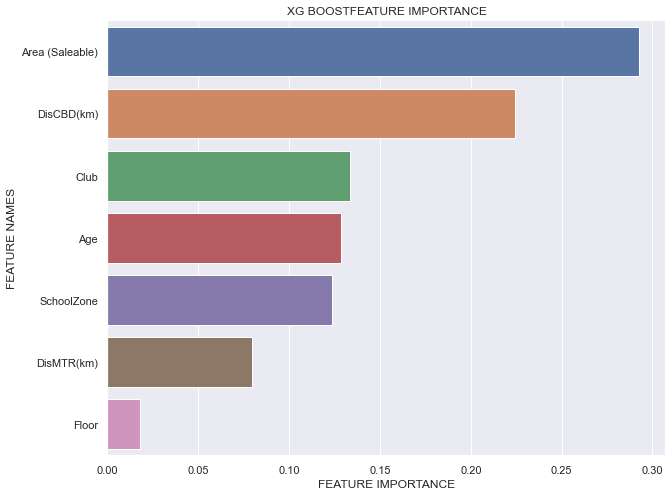

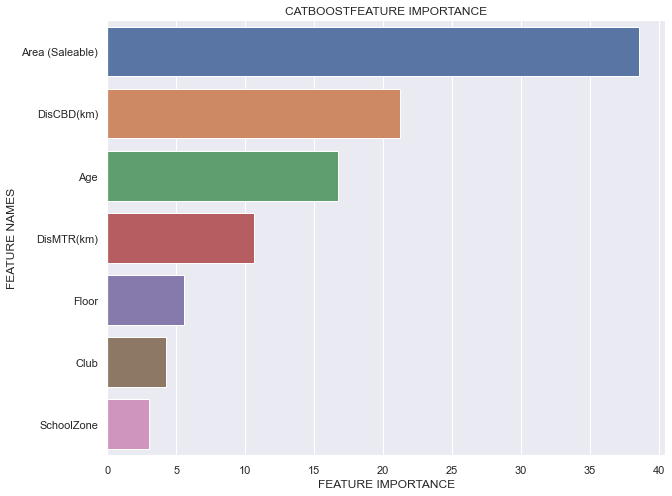

In [44]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(vr.estimators_[1].feature_importances_,X_train.columns,'XG BOOST')
plot_feature_importance(vr.estimators_[0].get_feature_importance(),X_train.columns,'CATBOOST')

# Testing our model and predicting

We will now predict the flat price in Hong Kong using real data from another website where we did not collect our dataset from (https://hk.centanet.com/). We will pick one from each district.

In [45]:
def predict_price(floor,area, age, club, DisMTR, 
                  DisCBD, SchoolZone):

    vars_list = [floor,area, age, club, DisMTR, 
                  DisCBD, SchoolZone]
    pred_df = pd.DataFrame(columns=X.columns)

    
    for variable, i in zip(vars_list,X.columns):
        pred_df.loc[0, i] = variable
        pred_df[i] = pred_df[i].astype(X.dtypes[i]) 
    
    pred_result = vr.predict(pred_df)
    
    return float(pred_result)
    

1.Belvedere Garden Phase 3 Block 5 14/F Flat A transacted on 2018-05-31 at HK$828(M)
https://hk.centanet.com/findproperty/transaction-detail/%E9%BA%97%E5%9F%8E%E8%8A%B1%E5%9C%92-3%E6%9C%9F_NJY202103R1444

In [46]:
predict_price(14,728,27.41,1,1.3,15.9,0)

843.6292048422964

2. Billionnaire Avant 18/F Flat C transacted on 2019-05-17 at HK$880(M)

https://hk.centanet.com/findproperty/transaction-detail/-_21042602090054

In [47]:
predict_price(18,465,4.58,1,1.2,9.3,1)

870.8568422199436

3. La Place de Victoria 41/F Flat Btransacted on 2018-10-18 at HK$2,100M
https://hk.centanet.com/findproperty/transaction-detail/-_21012200040095

In [48]:
predict_price(41,849,3,1,0.5,5.9,0)

2375.476871353323